# Topic Modeling Hilary Clinton Emails

**Addressable Business Challenge:** The United States House of Representatives has spent in excess of **$20 million** across 8 committees investigating the events concerning the 2012 attack on the US Libyan Embassy and subsequent private email server of Hillary Clinton

### Dataset: Hilary Clinton Emails sourced from Kaggle

**Original Data**  
[FOIA Hillary Clinton Emails](#https://foia.state.gov/searchapp/DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739681/C05739681.pdf)

### Research Question: How to best explore and visualize email content without reading through them?

### Goals: 
#### 1) Summarize emails
#### 2) Show relationships between emails and content
#### 3) Highlight content topics across emails

[Topic Model Research Paper](#https://www.aaai.org/ocs/index.php/ICWSM/ICWSM12/paper/viewFile/4645/5021)

In [151]:
#https://github.com/dougkelly/TopicModeling_HilaryClintonEmails/blob/master/.ipynb_checkpoints/Final_Project_DK_HilaryClintonEmails-checkpoint.ipynb


# Data Collection & Data Containers
import sqlite3
from collections import Counter, defaultdict

# Data Cleanup & Exploratory Data Analysis
# import email  - didn't work on raw email txt
import re
import numpy as np
import pandas as pd
import ftfy
import pycountry


# Modeling: Part 1
from textblob import TextBlob
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
# Modeling: Part 2
import gensim


# Visualization
import matplotlib.pyplot as plt
import seaborn
from wordcloud import WordCloud
%matplotlib inline

In [461]:
con = sqlite3.connect('data/Emails/database.sqlite')

In [462]:
emails = pd.read_sql_query("SELECT * FROM Emails", con)

In [14]:
# people = pd.read_sql_query("SELECT * FROM Persons", con)

## Exploratory Data Analysis Work with a helping of data cleanup

In [13]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7945 entries, 0 to 7944
Data columns (total 22 columns):
Id                              7945 non-null int64
DocNumber                       7945 non-null object
MetadataSubject                 7945 non-null object
MetadataTo                      7945 non-null object
MetadataFrom                    7945 non-null object
SenderPersonId                  7945 non-null object
MetadataDateSent                7945 non-null object
MetadataDateReleased            7945 non-null object
MetadataPdfLink                 7945 non-null object
MetadataCaseNumber              7945 non-null object
MetadataDocumentClass           7945 non-null object
ExtractedSubject                7945 non-null object
ExtractedTo                     7945 non-null object
ExtractedFrom                   7945 non-null object
ExtractedCc                     7945 non-null object
ExtractedDateSent               7945 non-null object
ExtractedCaseNumber             7945 non-null 

In [39]:
# emails.MetadataPdfLink.ix[104]

In [463]:
# Pulling out years and months to make slicing easier later
emails.MetadataDateSent = pd.to_datetime(emails.MetadataDateSent)
emails['Year'] = emails['MetadataDateSent'].dt.year
emails['Month'] = emails['MetadataDateSent'].dt.month

In [464]:
# Dropping unused or unreferenced columns
emails = emails.drop(['MetadataPdfLink','DocNumber', 'ExtractedDocNumber', 'MetadataCaseNumber'], axis=1)

In [465]:
# Dropping emails with > 10 words because of little topic value
emails = emails[emails.RawText.str.len()>10]

**Email lengths are heavily right skewed**

In [466]:
email_counts = emails.RawText.apply(len)
email_counts.describe()

count     7944.000000
mean      2390.303877
std       4749.452483
min        217.000000
25%        598.000000
50%       1056.000000
75%       2309.250000
max      98172.000000
Name: RawText, dtype: float64

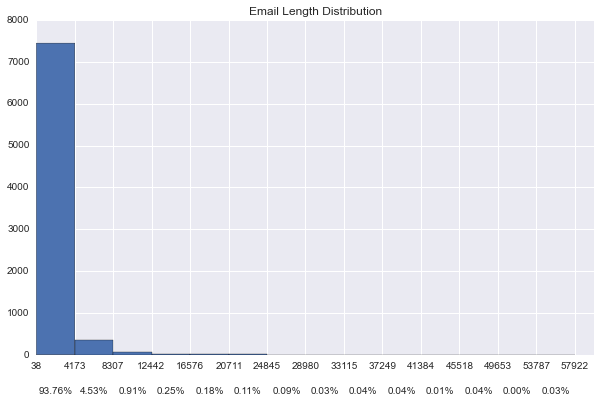

In [317]:
# Referenced for assistance with percentages along bottom: http://stackoverflow.com/questions/6352740/matplotlib-label-each-bin
fig, ax = plt.subplots(figsize=(10,6))
# Set bins = 12 because it divides evenly into 7944 total emails
counts, bins, patches = ax.hist(emails.RawText.apply(len), bins=14)
# Setting bins down below for more insight into length of emails
ax.set_xticks(bins)
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
for count, x in zip(counts, bin_centers):
    percent = '{:.2f}%'.format((float(count) / counts.sum())*100)
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
    xytext=(0, -32), textcoords='offset points', va='top', ha='center')
plt.title('Email Length Distribution');

**Discussion: Highly right skewed distribution with many short word length emails; based on initial topic modeling research, LDA and other probabilistic models may have trouble high volumes of short documents**

In [20]:
emails.Year.value_counts()

2010    4013
2009    3494
2012     250
2011      52
2014       2
2008       1
Name: Year, dtype: int64

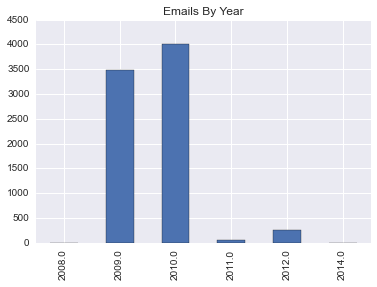

In [21]:
# Graph of the information above; heavily favors 2009 and 2010 with focus on Libya
emails.Year.value_counts(sort=False).plot(kind='bar')
plt.title('Emails By Year');

In [22]:
# Looking at monthly distribution
pd.crosstab(emails.Year,emails.Month)

Month   1    2    3    4    5    6    7    8    9    10   11   12
Year                                                             
2008     0    0    0    0    1    0    0    0    0    0    0    0
2009     5    0   46  179  384  330  329  462  521  394  377  467
2010   558  505  357  323  364  312  164  340  302  285  258  245
2011     2    0   14   16    4    5    0    7    3    1    0    0
2012    13    4    2    6    0    0    5    6  116   54   25   19
2014     0    0    0    0    0    0    0    1    0    0    0    1

### Hillary Clinton doesn't always follow the law, but she does, she follows Heap's Law

In [ ]:
# emails.RawText.unique()

In [577]:
def plot_heaps(emails):
    """
    Plots Heap's Law for Hilary Clinton Emails
    Debug shoutout Hollis Nolan
    """
    unique_words = set()
    for index, email in enumerate(emails):
        email_tokens = set(TextBlob(email).tokens)
        for token in email_tokens:
            if not token in unique_words:
                unique_words.add(token)
        plt.scatter(index,len(unique_words))
    plt.title("Heap's Law in Hillary Clinton Emails")
    plt.xlabel('Number of Documents')
    plt.ylabel('Number of Unique Words')
    print "Number of unique tokens (post-cleanup): {}".format(len(unique_words))

Number of unique tokens (post-cleanup): 41961


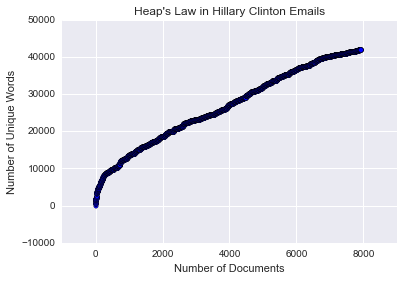

In [578]:
plot_heaps(emails_cleaned.RawText)

### Countries Mentioned in Emails

In [28]:
countries_lookup = {}

# Grab countries objects
countries = list(pycountry.countries)

# Fill dict with [2 letter codes] : country names
for country in countries:
    countries_lookup[country.alpha2]=country.name

country_names = list(countries_lookup.values())
country_names = [country.lower() for country in country_names]
country_names = set(country_names)
country_names.add('syria')

In [165]:
# [type(country) for country in country_names]

In [29]:
def country_counts(emails, country_names):
    country_mentions = defaultdict(int)
    for email in emails:
        email_tokens = email.split()
        if 'libyan' in email_tokens:
            country_mentions['libya'] += 1
        elif 'syrian' in email_tokens:
            country_mentions['syria'] += 1
        else:
            intersect = country_names.intersection(email_tokens)
            for match in intersect:
                    country_mentions[match] += 1
    return country_mentions

In [30]:
country_test = emails.RawText
c_mentioned = Counter(country_counts(country_test, country_names))

In [31]:
c_counts = [value[1] for value in c_mentioned.most_common(20)]
c_countries = [value[0] for value in c_mentioned.most_common(20)]

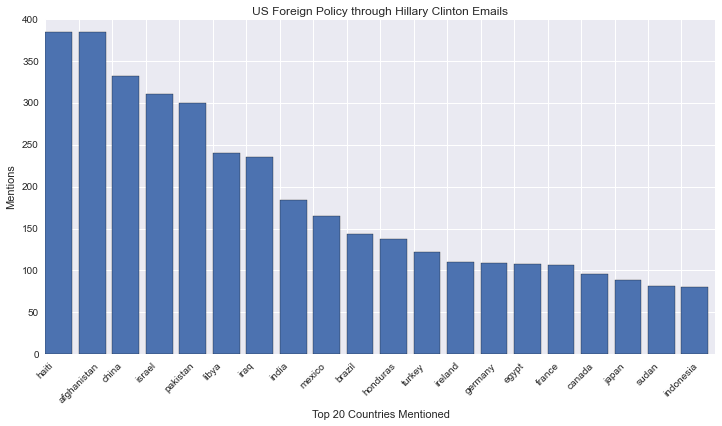

In [32]:
# Referenced: http://stackoverflow.com/questions/16010869/python-plot-a-bar-using-matplotlib-using-a-dictionary
plt.figure(figsize=(12,6))

plt.bar(range(len(c_counts)), c_counts)
plt.xticks(range(len(c_counts)), c_countries, rotation=45, ha='center')

plt.title('US Foreign Policy through Hillary Clinton Emails')
plt.xlabel('Top 20 Countries Mentioned')
plt.ylabel('Mentions')
plt.show()

### 2008; 1 garbage email, drop candidate

In [18]:
emails[emails.Year == 2008].MetadataSubject

1774    PPERSPECTIVE ON USAID CONTRACTING MEDHANISMS
Name: MetadataSubject, dtype: object

### 2009 Healthcare, Congressional Republicans

In [79]:
emails_2009 = emails[(emails.Year == 2009) & (emails.Month == 9)][30:40]

In [80]:
emails_2009[['Year','Month','MetadataFrom','MetadataTo', 'MetadataSubject']]

Year  Month     MetadataFrom           MetadataTo  \
710  2009      9  Hillary Clinton          Huma Abedin   
711  2009      9  Hillary Clinton         Cheryl Mills   
712  2009      9  Hillary Clinton              ntanden   
713  2009      9  Hillary Clinton                        
714  2009      9  Hillary Clinton   jilotylc@state.gov   
715  2009      9  Hillary Clinton  valmorolj@state.gov   
716  2009      9  Hillary Clinton         Cheryl Mills   
717  2009      9  Hillary Clinton  valmorolj@state.gov   
718  2009      9  Hillary Clinton  verveerms@state.gov   
719  2009      9  Hillary Clinton          Huma Abedin   

                                       MetadataSubject  
710                                                RE:  
711                                  SECRETARY'S EMAIL  
712                                        HEALTH CARE  
713  DEVIN AND I WANDERED INTO A CORNER OF THE HEAL...  
714                                          CALL LIST  
715                                           SCHEDULE  
716           POSSIBLE RIESER CALL ON FOREIGN OPS BILL  
717                                           SCHEDULE  
718                                             SWANEE  
719                                               CALL

In [36]:
emails_2009_2 = emails[(emails.Year == 2009)]

In [37]:
countries_2009 = Counter(country_counts(emails_2009_2.RawText, country_names))

In [38]:
c2009_counts = [value[1] for value in countries_2009.most_common(20)]
c2009_countries = [value[0] for value in countries_2009.most_common(20)]

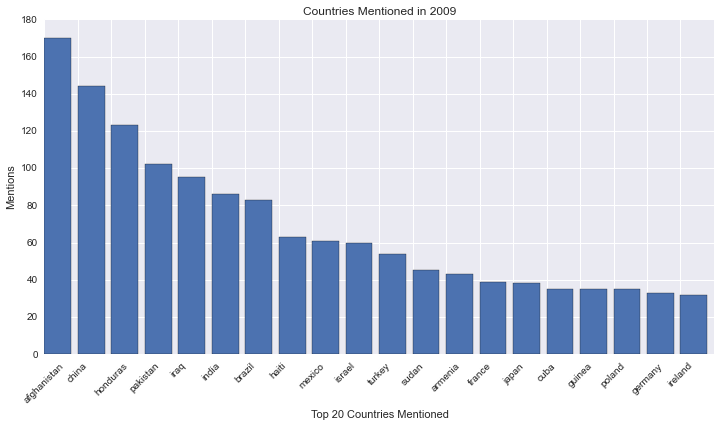

In [40]:
plt.figure(figsize=(12,6))

plt.bar(range(len(c2009_counts)), c2009_counts)
plt.xticks(range(len(c2009_counts)), c2009_countries, rotation=45, ha='center')

plt.title('Countries Mentioned in 2009')
plt.xlabel('Top 20 Countries Mentioned')
plt.ylabel('Mentions')
plt.show()

### 2010; Libya, Haiti, Israel & Palestine, Northern Ireland, Iran Sanctions, Arab Spring (Dec)

In [41]:
emails_2010 = emails[(emails.Year == 2010)]

In [42]:
emails_2010[['Year','Month','MetadataFrom','MetadataTo', 'MetadataSubject']][4000:4010]

Year  Month      MetadataFrom       MetadataTo  \
7931  2010     12      Cheryl Mills  Hillary Clinton   
7932  2010     12     Jake Sullivan  Hillary Clinton   
7933  2010     12          sbwhoeop  Hillary Clinton   
7934  2010     12       Huma Abedin  Hillary Clinton   
7935  2010     12       Huma Abedin  Hillary Clinton   
7936  2010     12      Cheryl Mills  Hillary Clinton   
7937  2010     12      Cheryl Mills  Hillary Clinton   
7938  2010     12     stern, todd d  Hillary Clinton   
7939  2010     12     Jake Sullivan  Hillary Clinton   
7940  2010     12  verma, richard r  Hillary Clinton   

                                        MetadataSubject  
7931                         EU STOPPED EURO 47 MILLION  
7932                                     MORE WIKITHINK  
7933                  H: JAMIE RUBIN FINALLY LANDS. SID  
7934  (AP) GERMANY: PULLOUT FROM AFGHANISTAN TO STAR...  
7935  (AP) PALESTINIANS SEEK STATE RECOGNITION IN EU...  
7936                                      FROM PAKISTAN  
7937                                          THE ENVOY  
7938                                             UPDATE  
7939                                      RICHARD (TNR)  
7940                                              WYDEN

In [84]:
# Richard Holbrooke death
# emails['RawText'].ix[7915]

In [86]:
# Protestant parades; should see Gordon Brown, Belfast, Mcguinness (North Ireland PM), republican
# Will be difficult to seperate Republicans in US vs. Northern Ireland party
# emails['RawText'].ix[3628]

In [100]:
# Bill Clinton cancelling on bro trip with Putin
# emails['RawText'].ix[7547]

In [44]:
countries_2010 = Counter(country_counts(emails_2010.RawText, country_names))
c2010_counts = [value[1] for value in countries_2010.most_common(20)]
c2010_countries = [value[0] for value in countries_2010.most_common(20)]

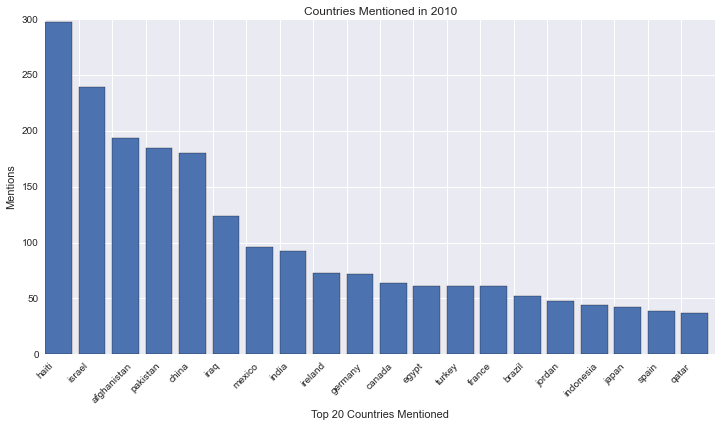

In [45]:
plt.figure(figsize=(12,6))

plt.bar(range(len(c2010_counts)), c2010_counts)
plt.xticks(range(len(c2010_counts)), c2010_countries, rotation=45, ha='center')

plt.title('Countries Mentioned in 2010')
plt.xlabel('Top 20 Countries Mentioned')
plt.ylabel('Mentions')
plt.show()

### 2011 Primarily collapse of Libya Government, deposition of Gaddafi. Sparse

In [46]:
emails_2011 = emails[(emails.Year == 2011)]

In [47]:
emails_2011[['Year','Month','MetadataFrom','MetadataTo', 'MetadataSubject']][:10]

Year  Month           MetadataFrom       MetadataTo  \
1   2011      3                         Hillary Clinton   
4   2011      3        Hillary Clinton      Huma Abedin   
7   2011      3        Hillary Clinton      Huma Abedin   
10  2011      3          Jake Sullivan  Hillary Clinton   
13  2011      3  slaughter, anne-marie  Hillary Clinton   
24  2011      3          Jake Sullivan  Hillary Clinton   
29  2011      3            Huma Abedin  Hillary Clinton   
32  2011      3                         Hillary Clinton   
40  2011      3          Jake Sullivan  Hillary Clinton   
43  2011      3        Hillary Clinton    Jake Sullivan   

                                      MetadataSubject  
1   H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...  
4   H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...  
7   H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...  
10             ABZ AN HBJ ON LIBYA AND WEST BANK/GAZA  
13  PIECE ON LIBYA NFZ THAT WILL APPEAR ON NYT OP-...  
24                                 PROPOSED QUAD DEAL  
29                              CHRIS STEVENS MISSION  
32  H: LOTS OF NEW INTEL; POSSIBLE LIBYAN COLLAPSE...  
40                                             LIBYAN  
43                                             LIBYAN

In [74]:
# Yikes. Chris Stevens update, request for more security. Quadafi cousin funded terror cell targeting hotels 
# emails['RawText'].ix[104]

In [49]:
countries_2011 = Counter(country_counts(emails_2011.RawText, country_names))
c2011_counts = [value[1] for value in countries_2011.most_common(20)]
c2011_countries = [value[0] for value in countries_2011.most_common(20)]

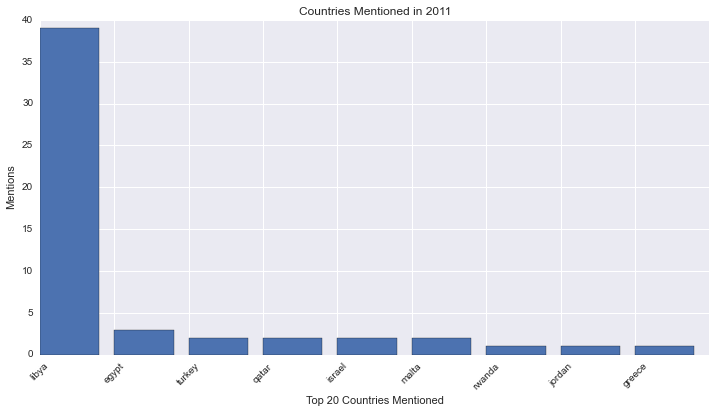

In [51]:
plt.figure(figsize=(12,6))

plt.bar(range(len(c2011_counts)), c2011_counts)
plt.xticks(range(len(c2011_counts)), c2011_countries, rotation=45, ha='center')

plt.title('Countries Mentioned in 2011')
plt.xlabel('Top 20 Countries Mentioned')
plt.ylabel('Mentions')
plt.show()

### 2012; Death Chris Stevens, Libya fallout

In [52]:
emails_2012 = emails[(emails.Year == 2012)]

In [53]:
emails_2012[['Year','Month','MetadataFrom','MetadataTo', 'MetadataSubject']][150:160]

Year  Month           MetadataFrom          MetadataTo  \
200  2012      1        Hillary Clinton                       
201  2012     11        Hillary Clinton        Cheryl Mills   
202  2012      9        Hillary Clinton  hanleymr@state.gov   
203  2012     11           Cheryl Mills     Hillary Clinton   
204  2012      1                            Hillary Clinton   
205  2012      9       hanley, monica r       Jake Sullivan   
206  2012     11  slaughter, anne-marie     Hillary Clinton   
207  2012      1          Jake Sullivan     Hillary Clinton   
208  2012     11           Cheryl Mills     Hillary Clinton   
209  2012     11        Hillary Clinton                       

                                       MetadataSubject  
200  H: LATEST INTEL LIBYAN CONFLICTS, LEADERS & MI...  
201                             POLITICO BREAKING NEWS  
202  LIBYANS MARCH AGAINST ISLAMIST MILITIAS IN BEN...  
203                         MARK - QUICK REUTERS QUERY  
204  H: LATEST INTEL LIBYAN CONFLICTS, LEADERS & MI...  
205                                              EDITS  
206  AN OP-ED YOU SHOULD READ; PRAISES STATE FOR WH...  
207  H: LATEST INTEL LIBYAN CONFLICTS, LEADERS & MI...  
208                             WSJ: HILLARY AND LIBYA  
209                             WSJ: HILLARY AND LIBYA

In [119]:
# taking serious heat in the press; key words like congressional hearing, petreaus, Libya failure
# emails['RawText'].ix[208]

In [54]:
countries_2012 = Counter(country_counts(emails_2012.RawText, country_names))
c2012_counts = [value[1] for value in countries_2012.most_common(20)]
c2012_countries = [value[0] for value in countries_2012.most_common(20)]

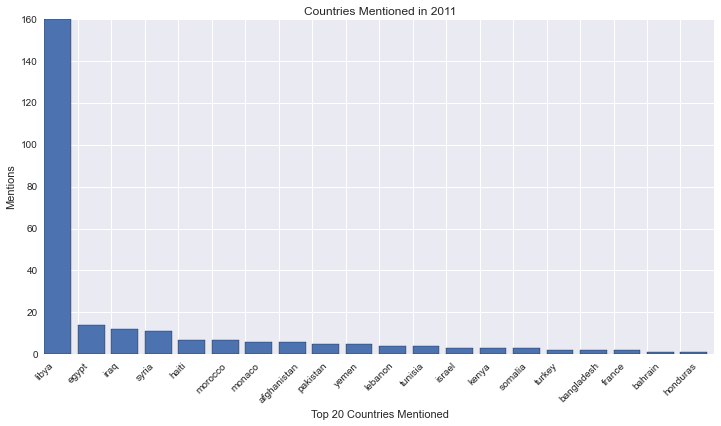

In [55]:
plt.figure(figsize=(12,6))

plt.bar(range(len(c2012_counts)), c2012_counts)
plt.xticks(range(len(c2012_counts)), c2012_countries, rotation=45, ha='center')

plt.title('Countries Mentioned in 2011')
plt.xlabel('Top 20 Countries Mentioned')
plt.ylabel('Mentions')
plt.show()

### 2013? Gap. Hillary Clinton resigns position as Secretary of State in February

### 2014? Drop candidates. Invite and State Department admin

In [27]:
emails_2014 = emails[(emails.Year == 2014)]

In [28]:
emails_2014[['Year','Month','MetadataFrom','MetadataTo', 'MetadataSubject']]

Year  Month      MetadataFrom       MetadataTo  \
4633  2014      8                                      
7914  2014     12  daniel, joshua j  Hillary Clinton   

                                        MetadataSubject  
4633  DRAFT AGENDA FOR 34TH ANNUAL COLP CONFERENCE A...  
7914                                             LETTER

In [141]:
# emails['RawText'].ix[7914]

## More Data Cleanup for Topic Modeling

In [ ]:
# Testing inital email cleanup reveals significant REGEX issues; 

In [161]:
emails['ExtractedBodyText'][6]

u''

In [55]:
emails['RawText'][6]

u'UNCLASSIFIED\nU.S. Department of State\nCase No. F-2015-04841\nDoc No. C05739560\nDate: 05/13/2015\nSTATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.\nSUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.\nRELEASE IN\nFULL\nFrom: Mills, Cheryl D <MillsCD@state.gov>\nSent: Wednesday, September 12, 2012 4:00 PM\nTo:\nSubject: FW: Anti-Muslim film director in hiding, following Libya, Egypt violence\nFrom: Toiv, Nora F\nSent: Wednesday, September 12, 2012 1:48 PM\nTo: Mills, Cheryl D\nSubject: Anti-Muslim film director in hiding, following Libya, Egypt violence\nAnti-Muslim film director in hiding, following\nLibya, Egypt violence\nBy Nia-Malika Henderson and Michelle Boorstein, Updated: Wednesday, September 12,\n1:30 PM\nThe director of a controversial anti-Islam film has gone into hiding, according to reports, fearing reprisals over a\nwork that has sparked violence in Egypt and Libya and led to the deaths of four Americans.\nSam Bacile, a California real esta

In [12]:
# 245 unique names
# emails.iloc[:,3].unique()

**Names Cleanup**

In [467]:
def name_cleanup(name):
    """
    Cleanup function to map real names to aliases 
    """
    # Normalizing tokens by lower casing
    name = str(name).lower()
    # Cheryl Mills
    if ('cheryl' in name) or ('mills' in name):
        return 'Cheryl Mills'
    # Jake Sullivan
    elif ('sullivan' in name):
        return 'Jake Sullivan'
    # Huma Abedin
    elif ('abedin' in name) or ('huma' in name):
        return 'Huma Abedin'
    # Hilary Clinton
    elif ('h' == name) or ("secretary" in name) or ('hillary' in name) or ('hilary' in name) or (';h' in name):
        return 'Hillary Clinton'
    # Prevents overwritting
    else:
        return name

In [468]:
emails.MetadataTo = emails.MetadataTo.apply(name_cleanup)
emails.MetadataFrom = emails.MetadataFrom.apply(name_cleanup)

**Email RawText Regex Cleanup**

In [469]:
def email_cleanup(email):
    """
    Cleaning up raw text of emails
    """
    # Normalizing tokens by lower casing
    email = email.replace('\n', " ").lower()

    patterns = [
    # # Remove From: LastName, FirstName, Optional Middle Initial
    r"from: (\w+), (\w+) (\w+)?",
    # Dates
    r"(date):? \d+/\d+/\d+",
    # # Remove Case Numbers. Example: Case No. F-2015-04841
    r"case no. \w-\d+-\d+",
    # # Remove times. Example: 12:08 PM
    r"[0-2]?[0-9]:[0-6][0-9] (am|pm)",
    # Removing Timestamps in Sent
    r"(sent|updated)?:? (monday|tuesday|wednesday|thursday|friday|saturday|sunday), (january|february|march|april|may|june|july|august|september|october|november|december) \d+, \d{4} \d{0,2}:\d{0,2} (am|pm)",
    # Remove emails
    r"[\w]+@[\.\w]+",
    # Dates 2
    r"(monday|tuesday|wednesday|thursday|friday|saturday|sunday)",
    # Removing months
    r"january|february|march|april|may|june|july|august|september|october|november|december",
    # Removing doc numbers
    r"doc no. \w?\d+",
    # Removing email footer STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.
    r"state dept. - produced to house select benghazi comm.",
    # Removing email footer SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS.
    r"subject to agreement on sensitive information & redactions.",
    # Removing email footer
    r"no foia waiver.",
    # Removing leftover characters
    r"[\@!<>()&-:';]",
    # remove all digits
    #r"\d"
    ]
    
    for pattern in patterns:
        email = re.sub(pattern, " ", email)
    return email

In [311]:
email_test = emails['RawText'][100]
# emails['RawText']

In [60]:
# emails['RawText'][190]

In [470]:
email_cleanup(email_test)

u'department state release part b sent cc schwerin daniel b subject ending speech b department state state cb'

In [60]:
# Testing Regex
test = 'Date: 05/13/2015'
pattern = r"(Date:)? \d+/\d+/\d+"
re.sub(pattern, " ", test)

'T '

**Text Encoding Cleanup**

**Master Tracker Objective: Write code using an existing NLP library that handles encoding errors (e.g., mojibake)**

In [471]:
# Brian Spering's example code + http://stackoverflow.com/questions/9942594/unicodeencodeerror-ascii-codec-cant-encode-character-u-xa0-in-position-20
emails.RawText = emails.RawText.apply(lambda x: x.encode('ascii', 'replace'))
emails.RawText = emails.RawText.apply(lambda x: x.decode('utf-8'))
emails.RawText = emails.RawText.apply(lambda x: ftfy.fix_text(x) if isinstance(x, unicode) else 'WARNING: bytes not unicode')

**Applying Text Cleanup to all Emails**

In [473]:
# Applying email cleanup function to raw text column
emails.RawText = emails.RawText.apply(email_cleanup)

**Experiment: TextBlob POS**

In [474]:
def tags_filter(text):
    """
    Experiment to just use Nouns, Verbs, Adjectives
    """
    blob = TextBlob(text).tags
    words = []
    for blob_tags in blob:
        # Nouns
        if blob_tags[1] in ("NN", "NNS", "NNP", "NNPS"):
            words.append(blob_tags[0])
        # Verbs
        if blob_tags[1] in ("VB", "VBD", "VBG", "VBN", "VBP", "VBZ"):
            words.append(blob_tags[0])
        # Adj
#         if blob_tags[1] in ("RB", "RBR", "RBS"):
#             words.append(blob_tags[0])
        words = [w for w in words if len(w) > 1]

    return " ".join(words)

In [475]:
test = emails.RawText[2]

In [476]:
tags_filter(test)

u'department state release part sent cc abedin huma subject re chris stevens thx message anne marie slaughter sent corn cc huma mills cheryl subject chris stevens colleagues fsos stand front lines soldiers do thinking everyone morning am department state state cb'

In [225]:
# test2.tags[]

**Experiment: TextBlob POS**

In [477]:
emails.RawText = emails.RawText.apply(tags_filter)

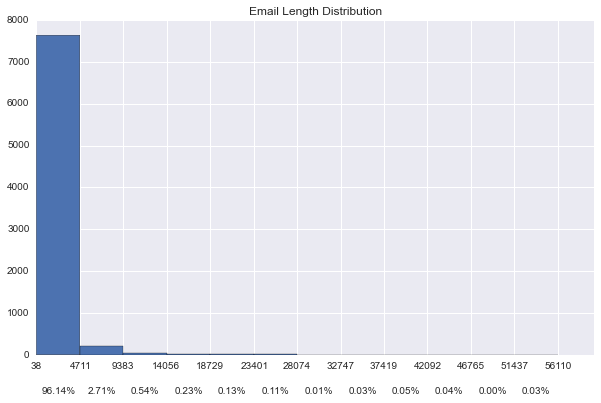

In [480]:
fig, ax = plt.subplots(figsize=(10,6))
# Set bins = 12 because it divides evenly into 7944 total emails
counts, bins, patches = ax.hist(emails.RawText.apply(len), bins=12)
# Setting bins down below for more insight into length of emails
ax.set_xticks(bins)
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
for count, x in zip(counts, bin_centers):
    percent = '{:.2f}%'.format((float(count) / counts.sum())*100)
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
    xytext=(0, -32), textcoords='offset points', va='top', ha='center')
plt.title('Email Length Distribution');

**To drop short emails or not?**

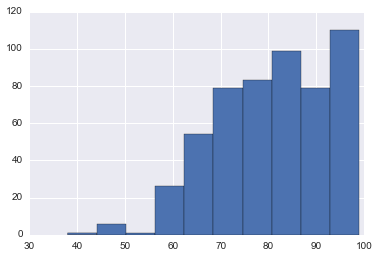

In [579]:
emails[emails.RawText.apply(len) < 100].RawText.apply(len).hist();

In [490]:
# emails[emails.RawText.apply(len)50]

# Topic Modeling: NMF & LDA

In [499]:
# Dropping 2008 and 2014 emails due to low email counts
emails_cleaned = emails[(emails.Year != 2008) & (emails.Year != 2014)]
# emails_cleaned.Year.value_counts()

X = emails_cleaned.RawText

**Adding Corpus-specific stop words**

In [501]:
# Iteratively extending stopword list
new_stopwords = ['foia', 'waiver', 'classified', 'unclassified', 
                 'redactions', 'sensitive', 'clintonemail', 'department', 
                 'dept', 'mailto', 'subject', 'fw', 'cc', 'state', 'send', 
                 'sent', 'comm', 'cheryl', 'mills', 'sullivan', 'www', 'url', 
                 'http', 'xml', 'html', 'org']
# Adding to stop words frozenset per Sklearn docs
my_stopwords = text.ENGLISH_STOP_WORDS.union(new_stopwords)

**Vectorizing emails using CountVectorizer (term frequencies); works best with LDA model**

In [502]:
# Experimented with increasing max features (the maximum number of words or phrases that are included in the vector model) to improve topic clarity
# Removed English stopwords
cv = CountVectorizer(max_features=10000, stop_words = my_stopwords, ngram_range=(1, 2), max_df=0.98)
cv_X = cv.fit_transform(X)
# print vectorized_X.toarray()
# Saving words
word_col = cv.get_feature_names()
word_col[:10]

[u'aa',
 u'aaron',
 u'abandon',
 u'abandoned',
 u'abandoning',
 u'abbas',
 u'abbas said',
 u'abc',
 u'abc news',
 u'abd']

**Using TFIDF normalization with TFIDF_Vectorizer; works best with NMF model**

In [414]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words = my_stopwords)
tfidf_X = tfidf_vectorizer.fit_transform(X)
word_col= tfidf_vectorizer.get_feature_names()
word_col[:10]

[u'aa',
 u'aaron',
 u'abandon',
 u'abandoned',
 u'abandoning',
 u'abbas',
 u'abc',
 u'abc news',
 u'abd',
 u'abd al']

## The hunt for k: finding the optimal number of topics

**Method 1 (fail): GridSearch number of topics on LDA with goal of maximizing LDA model score (maximum likelihood); Sklearn implementation not performant enough**

**Method 2 (success): NMF figure out best W and H that best recreates original matrix**

**Method 3: (future direction): Use complementary clustering (kmeans) to identify number of topics**

**Method 4 (future direction): Cross validation using topic stability analysis (per research)**

**Sparse matrices to the rescue**

In [332]:
from scipy import sparse

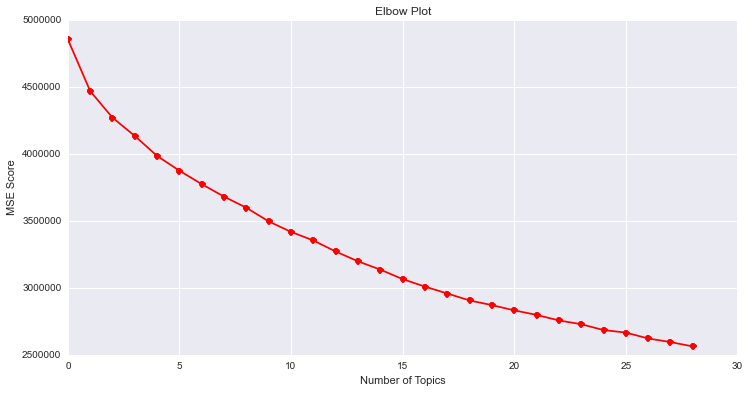

In [611]:
plt.figure(figsize=(12,6))
plt.title("Elbow Plot")
plt.xlabel("Number of Topics")
plt.ylabel("MSE Score")
errors = []
for k in xrange(1,30):
    nmf = NMF(n_components=k).fit(cv_X)
    W = nmf.fit_transform(cv_X);
    H = nmf.components_
    predicted = sparse.csr_matrix(W.dot(H))
    og_sparse = sparse.csr_matrix(cv_X)
    diff = np.absolute(og_sparse - predicted)
    errors.append(np.sum(np.square(diff.data)))
plt.plot(np.arange(k), errors, c='r', linestyle='-', marker= 'o');

**Interpretted plot as suggesting 11 number of topics is optimal. However, found 24 number of topics provided clearer seperation of topics by foreign policy events**

## Non-Negative Matrix Factorization (NMF)

**Model 1: 11 topics**

In [590]:
# Source Code: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/decomposition/nmf.py
# Pick n_components: http://derekgreene.com/howmanytopics/
nmf = NMF(n_components=11).fit(cv_X)

In [591]:
W = nmf.fit_transform(cv_X);
H = nmf.components_

In [592]:
# W (n_emails, n_topics)
W.shape

(7941, 11)

In [593]:
# H (n_topics, n_features)
H.shape

(11, 10000)

In [507]:
# emails_topic
emails_topic = pd.DataFrame(W)
# emails_topic

In [508]:
emails_topic.insert(0, column='Subject', value=emails_cleaned.ExtractedSubject)
emails_topic.insert(1, column='Year', value=emails_cleaned.Year)
emails_topic.insert(2, column='Month', value=emails_cleaned.Month)

**Model 2: 24 Topics**

In [612]:
nmf2 = NMF(n_components=24).fit(cv_X)
W2 = nmf2.fit_transform(cv_X);
H2 = nmf2.components_

In [613]:
# W (n_emails, n_topics)
W2.shape

(7941, 24)

In [614]:
# H (n_topics, n_features)
H2.shape

(24, 10000)

### Topics by Year: exploring relationship of topics across time

In [534]:
def topic_EmailsPerYear(topic, doc_topic, X):
    """
    Function to return count of emails with topic per year
    """
    # All emails that contain topic
    emails_with_topic = doc_topic[:,topic].nonzero()
    # 
    emails_with_topic = X[['Year','MetadataSubject']].ix[emails_with_topic]
    emails_year_topic = emails_with_topic.groupby('Year').apply(len)
    emails_year_topic.plot(kind='barh', color='green', title='Topic {:}: Emails Counts by Year'.format(topic))
    plt.ylabel('Year', rotation=0)
    print 'Topic {}: {:.2%} of total emails'.format(topic, emails_year_topic.sum() / 7994.0)
    print emails_year_topic

Topic 10: 51.58% of total emails
Year
2009    1854
2010    2171
2011      26
2012      72
dtype: int64


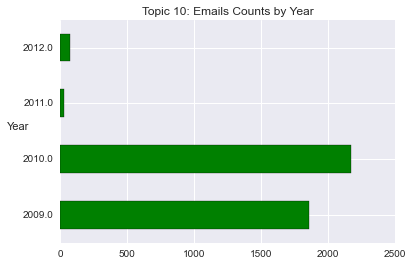

In [535]:
topic_EmailsPerYear(10, W, emails_cleaned)

Topic 15: 27.92% of total emails
Year
2009     894
2010    1183
2011      32
2012     123
dtype: int64


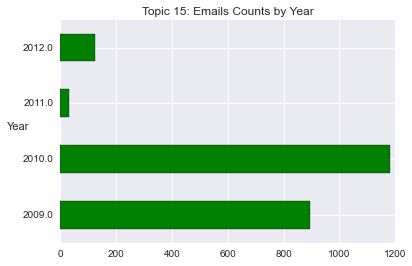

In [536]:
topic_EmailsPerYear(15, W, emails_cleaned)

### Topics By Email: Exploring topic breakdown of specific emails

In [529]:
# Top Emails by Topic
def topic_topEmails(topic, n_emails, X, doc_topics):
    topN_topic_email = doc_topics[:,topic].argsort()[::-1][:n_emails]
    return X[['Year','MetadataSubject']].ix[topN_topic_email]

**Model 1: 11 topics**

In [542]:
topic_topEmails(7, 10, emails_cleaned, W)

Year                                    MetadataSubject
3766  2010  A COUPLE OF POWERFUL QUOTES FROM FOREIGN MEDIA...
3768  2010            U/S MCHALE'S SCHEDULE 1/28/10 - 2/9/210
2225  2009                                                   
3799  2009                            END OF THE GOLDMAN CASE
4057  2010                                              SHAUN
2048  2009                          CALL WITH SEN. LAUTENBERG
3523  2009        AMNESTY INT'L ON SECRETARY CLINTON'S SPEECH
6645  2010    (AP) SERBIAN ANTI-GAY RIOTS WRONG MESSAGE TO EU
234   2012                                           SCHEDULE
3956   NaN  SUCCESSFULLY ENGAGING GLOBAL MEDIA ABOUT THE U...

**Model 2: 24 topics**

In [619]:
topic_topEmails(7, 10, emails_cleaned, W2)

Year                                    MetadataSubject
6524  2010  (THE DETROIT NEWS) BURNED QURAN SMEARED WITH F...
5941  2010                                    FROM JOE WILSON
7695  2010                                                AFP
5638  2010                                    DALTON HATFIELD
5127  2010                                                FYI
6075  2010                              MASHABANE CALL UPDATE
4662  2010              WP GRATION ITEM IN CASE YOU MISSED IT
5158  2010                                    NI/TACTIC WORKS
7456  2010                                       INFO FOR YOU
4455  2010                               OUR PROPOSED READOUT

In [318]:
# H_test = pd.DataFrame(H, columns=word_col)

### Topics by Words & Word Clouds

**Exploring soft topic clusters**

In [597]:
# Referenced NMF package doc pages for plot ideas: http://nimfa.biolab.si/nimfa.examples.documents.html
def topic_TopWords(model, feature_names, n_top_words):
    """
    Function for printing % words contained by topic, n_top_words sorted by length,
    and plots top 10 words by importance per topic
    """
    for topic_idx, topic in enumerate(model.components_):
        
        print "\n Topic {}: \n".format(topic_idx+1)
        print "Percentage of Words: {:.2%}\n".format(np.count_nonzero(topic) / 41961.)
        top_words = [feature_names[i] for i in topic.argsort()[::-1][:n_top_words]]
        print ' '.join(sorted(top_words,key=len,reverse=True))
        top10_idx = topic.argsort()[::-1][:10]
        value = sorted(topic[top10_idx],reverse=False)
        
        # Horizontal Bar Plots of Top 10 weighted terms
        plt.figure(topic_idx + 1)
        plt.barh(np.arange(10) + .5, value, color="green", align="center")
        plt.yticks(np.arange(10) + .5, [feature_names[i] for i in topic.argsort()[::-1][:10]])
        plt.xlabel("Weight")
        plt.ylabel("Term")
        plt.title("Top 10 Highest Weighted Terms in Topic {}".format(topic_idx + 1))
        plt.grid(True)
        plt.show()

**Model 1: 11 Topics**


 Topic 1: 

Percentage of Words: 18.78%

united states afghanistan development governments government ambassador colleagues countries secretary president indonesia diplomacy including americans security pakistan violence american minister benghazi continue support country working efforts message embassy morocco leaders nations meeting service america protect believe friends people united states future attack health afghan region world today women libya haiti thank force china years chris peace build trade work help said want need know time year make week iraq look let scb way men war aid


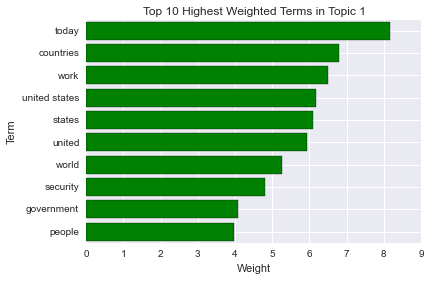


 Topic 2: 

Percentage of Words: 12.71%

strategies performance performance indicators diplomacy affairs african affairs africa bureau coordination implications needed begin start timing performance information plan action development strategies indicators engagement washington diplomacy pdpa plan expertise resources audiences positions outreach position officers increase diaspora af pdpa affairs african support officer offices program actions process mission results africa office bureau policy needed action pd das timing deputy media goals posts field begin start paper staff based desks pdpa plan lead desk work type paco paos pao das jan feb af pd fy pa ii


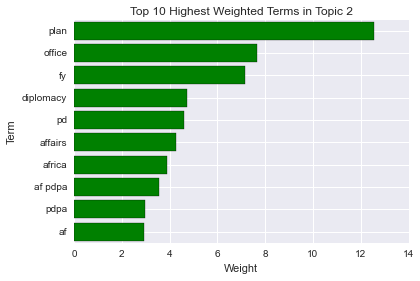


 Topic 3: 

Percentage of Words: 12.44%

question secretary secretary clinton clinton question hillary clinton right question clinton right relationship right right secretary president everybody question laughter philippe minister security clinton hillary thought country meeting believe working message service people monica office branch wanted trying person right think going world staff thing china phone house years asean mean said know want time gore trip kind work make came didn told feel went tell life did lot don say scb wjc hrc day way try got job let ve ll


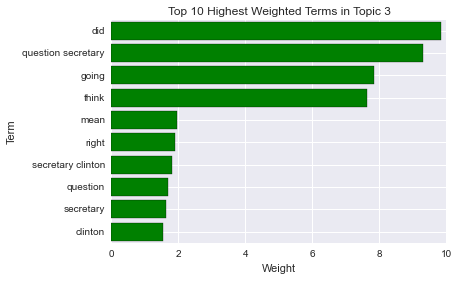


 Topic 4: 

Percentage of Words: 10.05%

ap_popover_sprited background image popover images images amazon lib popover electronics instruments improvement amazon com ecx images com images background newspapers image ecx magazines furniture utf node gomorrah shipping supplies computer software popover reading apparel product message amazon images com gp kindle sports health search author garden movies demand reader corner books video image games music trial tools store blogs node home list baby kids gift wish used care book game lawn com ref utf ecx gif png max lib add day gp dp mp pc


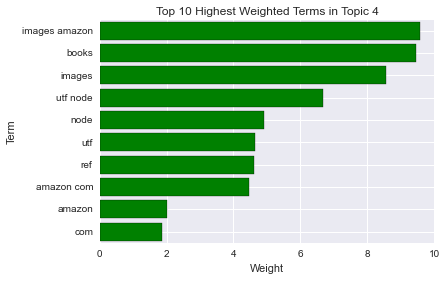


 Topic 5: 

Percentage of Words: 14.49%

patriarch bartholomew freedom religion constantinople patriarchate archons news nationalists organization authorities bartholomew communities government christians minorities patriarch ergenekon christian officials catholics community explosion according cathedral istanbul news asp armenian reported property security churches catholic religion compound european officers minority archons freedom grenade threats members attacks article reports alleged windows turkey church police asp id people muslim rights groups murder ankara george called greek party right court turks world news said bomb case time used city asp akp mit id st


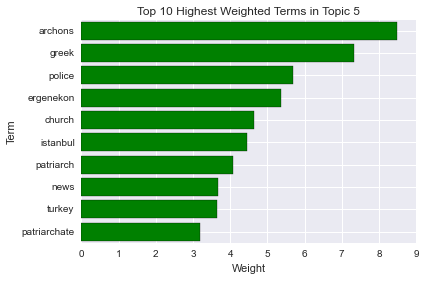


 Topic 6: 

Percentage of Words: 12.80%

administration united states peace process palestinians saudi arabia relationship palestinian settlements government washington settlement occupation initiative netanyahu jerusalem west bank interests palestine diplomacy americans community terrorism president american israelis security minister european conflict tomorrow israeli process leaders america zionism support parties actions islamic israel states united middle rights called arabia muslim region people effort groups peace arabs saudi world talks right years obama arab jews land west make gaza bank time iran does oslo way war did end com


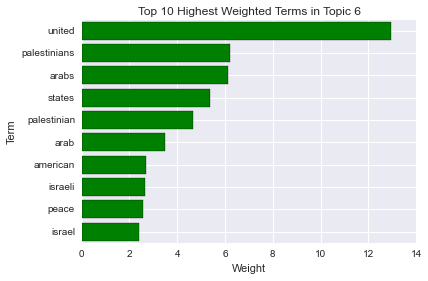


 Topic 7: 

Percentage of Words: 12.23%

according source source comment intelligence governments el magariaf government supporters according president situation officials concerned abushagur establish al juwali magariaf minister security militias believes benghazi fighting islamist egyptian services advisors el keib qaddafi opinion comment leaders sources council militia cabinet islamic country believe control tripoli support misrata members efforts source libyan forces belhaj stated regime effort groups access attack troops haftar juwali libya jalil egypt added firms keib army time said oil ntc scb sid gnc lmb jcp el al


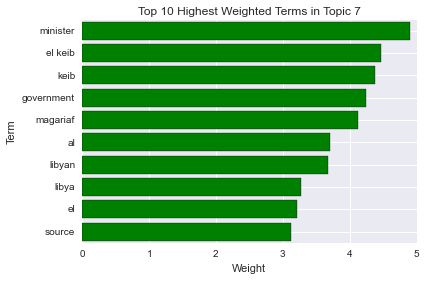


 Topic 8: 

Percentage of Words: 16.68%

republicans health care care reform legislation filibuster washington amendments democrats committee alexander mcconnell amendment president senators majority democrat senator members chamber message senate reform health corker debate leader baucus office people called caucus things branch house floor party rules udall votes press place staff asked money gregg years right voted said vote care time dodd year days know reid want rule went work deal make told come took day did tom way don com say let end


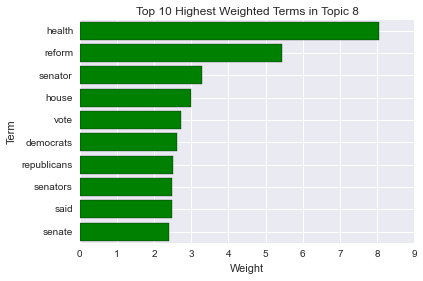


 Topic 9: 

Percentage of Words: 11.46%

assistance programs agency development discussion draft united states administrator states agency effectiveness coordination development assistance discussion evaluation activities government management priorities committees subsection including personnel paragraph resources secretary president appointed workforce following positions programs research director analysis strategy congress agencies capacity planning employee expenses officers training services program section service support include members develop states united agency policy report office filled design assist member duties group draft board usaid funds title years year term ment work date act mdm ii


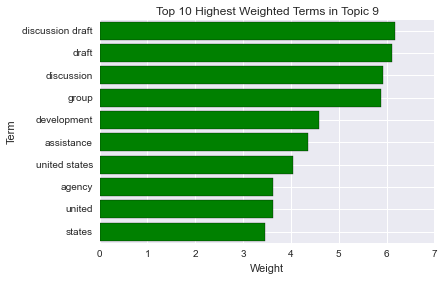


 Topic 10: 

Percentage of Words: 17.05%

americans prosperity koch industries administration afghanistan washington government david koch prosperity industries president tea party americans institute campaign american movement election politics brothers position mr obama strategy clinton charles company dollars america percent country adviser policy people office center branch called change voters filled health family george obama party house david kochs years right think group times going money koch said told time bush says year beck wing care york john role tea did say war don day way mr


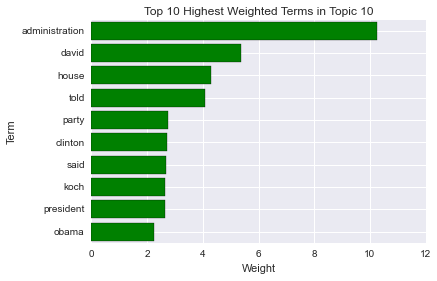


 Topic 11: 

Percentage of Words: 14.07%

ambassador moriarty michael pelletier concludes depart secretary office travelling party kitty dimartino american center lynne gadkowski minutes arrive pelletier cpao judith mchale party embassy time minutes depart hotel corley kenna participants staff judith joe mellott hotel route drive time ambassador travelling bangladesh pelletier dimartino secretary concludes consulate residence gadkowski american director minister briefing moriarty michael meeting minutes mellott embassy message airport pao joe program depart arrive mchale judith office center mumbai editor wheels corley route drive hotel staff kitty india delhi kenna press media dhaka lynne lunch time cpao room huma pao joe usg ron


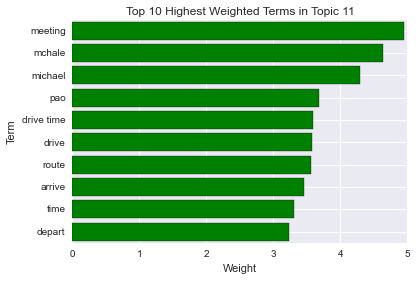

In [598]:
topic_TopWords(nmf, word_col, 75)


 Topic 1: 

people government security world united states united states work countries today pakistan violence support women american country afghanistan help minister development said working secretary libya president efforts benghazi indonesia haiti ambassador want need thank future force attack know message embassy let morocco diplomacy china years leaders continue time year chris make week nations health iraq meeting scb service america including peace protect governments americans way afghan men build believe region colleagues trade friends look war aid effort conflict lives needs come nation policy issues day diplomats personnel leadership provide progress information democracy cooperation rights risk building values asean justice partners asia


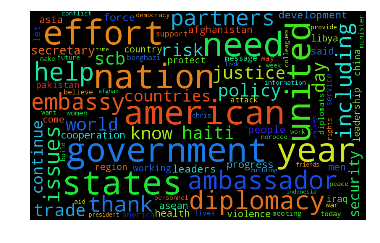


 Topic 2: 

af pdpa af pdpa africa affairs pd diplomacy fy office plan bureau media policy goals strategies african support diplomacy affairs officer outreach position pdpa plan performance pao lead posts coordination field officers pa offices needed expertise desk action resources work das pd das type begin audiences program start paco indicators ii actions timing implications needed begin strategies performance start timing performance indicators engagement information paper staff paos process washington increase deputy diaspora plan action based mission results africa bureau development jan positions feb african affairs desks training making american people goals ii leadership engage activities pd desk priorities communications understanding pdod pd desks timing fy space assistant policy making coordinator analysis portfolio priority bureau african role goal


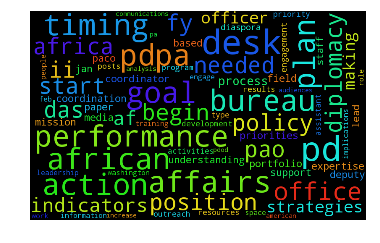


 Topic 3: 

clinton secretary question secretary clinton right mean think going question secretary did said laughter people ve know clinton question president lot don hillary want monica office world branch clinton right say time thought right question scb wjc hrc wanted gore day trip kind country staff thing work china everybody trying philippe meeting phone way make came believe didn told try house working feel went message ll got relationship person tell service years minister right right security hillary clinton life job asean let saying issues asia profile course look administration talking don know conference secretary office policy room given talk somebody press asked home does chelsea dinner talked week come


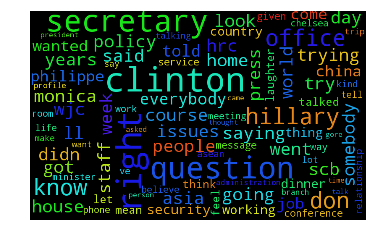


 Topic 4: 

com amazon amazon com ref utf node utf node images books images amazon ecx images ecx com images gp com gp kindle gif png home max dp video image background lib lib popover background image popover popover images image ecx sports ap_popover_sprited list games add baby kids gift wish used health search author magazines music reading gomorrah trial mp apparel tools product garden shipping store supplies day electronics newspapers computer blogs care book software movies instruments game pc improvement demand reader corner lawn furniture message action media party food office women power light learn health care device york car shoes exercise enter idea industry times movement diseases help sign year beck


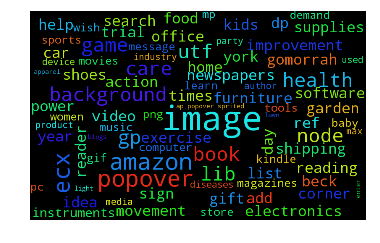


 Topic 5: 

patriarchate turkey news patriarch istanbul church ergenekon police greek archons government id said authorities freedom asp asp id party christians bartholomew christian patriarch bartholomew news asp archons news bomb case constantinople right court grenade akp officials threats minorities nationalists members people armenian reported muslim property time turks attacks rights world st security churches catholics groups article murder community catholic ankara religion compound european explosion george mit communities used reports alleged called organization windows officers city according freedom religion minority cathedral roof life treaty times media official office murders group belief harassment circles hand statement years army dr day america leaders views armed trial demonstrations shattered


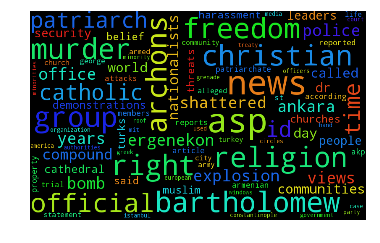


 Topic 6: 

israel peace israeli american arab palestinian states arabs palestinians united united states netanyahu jews process israelis leaders land middle west america peace process make gaza saudi administration jerusalem security rights way world war zionism government west bank bank interests talks called time iran did end palestine minister saudi arabia arabia right washington support diplomacy parties muslim region years people com obama americans does effort european settlements conflict community terrorism actions relationship tomorrow settlement groups occupation oslo islamic president initiative policy muslims conference party self want lieberman things council hamas times media share luntz center year peace initiative issue arab peace speech partner message students reasons begin


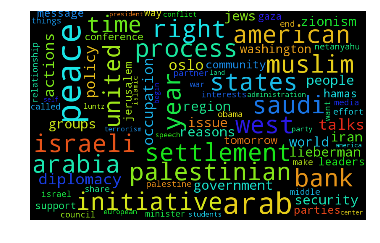


 Topic 7: 

source el libya libyan al magariaf government keib el keib minister qaddafi according security jalil forces president oil ntc militias believes opinion belhaj situation scb benghazi comment source comment intelligence army fighting stated islamist leaders according source regime sid time governments egypt sources council militia cabinet effort egyptian added officials islamic concerned gnc country groups services access believe abushagur control tripoli advisors attack troops support firms haftar misrata said el magariaf members lmb juwali establish jcp efforts al juwali supporters european region libyan council leader brotherhood role hrc intelligence security nfa comment opinion revolution muammar mangoush staff noted security services abdel attacks sources access individuals source el levels leadership ali zidan


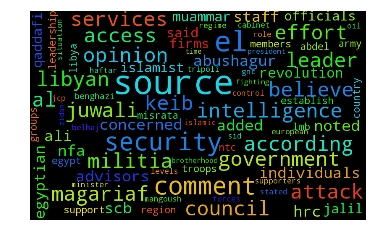


 Topic 8: 

senate said senators republicans democrats vote house senator reform health care health care time corker dodd floor members party chamber committee majority rules debate year days leader know baucus reid alexander udall day care reform filibuster mcconnell votes amendment want rule office press people washington went called did tom way don work place deal democrat com amendments staff legislation say make president told message asked come caucus things let branch end money gregg years right took voted think room industry issue minority passed ve levin got warner institution mccaskill lobbyists thomas spent john hold wjc parties going cloture mr began gore times


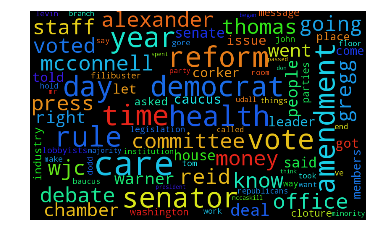


 Topic 9: 

states united agency united states assistance development group discussion draft discussion draft programs policy evaluation program research report section office including director administrator analysis activities government act assistance programs year strategy congress personnel agency development board states agency service term usaid mdm agencies capacity planning employee funds paragraph resources ii ment management filled secretary president priorities committees work expenses subsection appointed workforce design date support effectiveness officers following training assist include member members coordination duties develop title services years positions use policy planning sec submit individuals states assistance implementing states government position operating required purposes account level health objectives information recommendations detailed pay budget employees organizations provided described


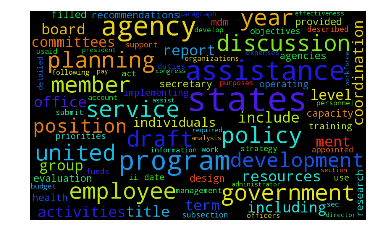


 Topic 10: 

obama president koch said clinton party told house david administration charles kochs tea policy years right mr tea party time campaign washington people bush company says american think americans group dollars movement government year election david koch did office politics america say war center branch called change prosperity don industries voters filled afghanistan health percent times koch industries beck day americans prosperity wing brothers care country going york john money family george position mr obama adviser way institute role strategy known news official health care economy left tax republicans power hillary com history according week panetta support spent right wing described board gore cancer street ve congress


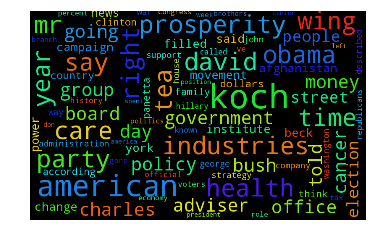


 Topic 11: 

depart time arrive route drive drive time pao michael mchale meeting hotel judith pelletier michael pelletier judith mchale minutes joe mellott time minutes joe mellott office embassy staff kitty dimartino kitty dimartino center secretary american india concludes minutes arrive usg consulate ambassador cpao room director mumbai pelletier cpao editor residence concludes depart message delhi secretary office wheels minister airport briefing corley kenna press moriarty depart hotel american center pao joe corley kenna media program participants travelling dhaka lynne ambassador moriarty travelling party bangladesh lunch huma hotel route gadkowski lynne gadkowski ron party embassy staff judith party pm location dinner hyatt alumni house participants judith mchale ambassador abedin access business sheraton executive conference elizabeth ministry david consul lobby mr goldman time arrive schedule president


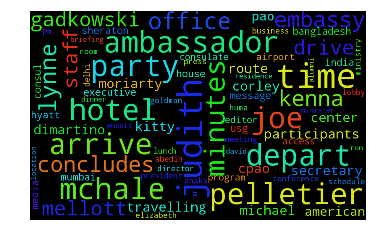

In [599]:
word_clouds(nmf, word_col, 100)

**Model 2: 24 Topics**

**Best Model; shows stability of topics with additional breaking out of new topics**


 Topic 1: 

Percentage of Words: 11.29%

united states governments government ambassador colleagues indonesia countries americans president secretary security violence benghazi american minister pakistan continue working morocco country support protect service friends america leaders believe efforts people united states attack future libyan world today libya thank chris women peace work want said help know week scb let men


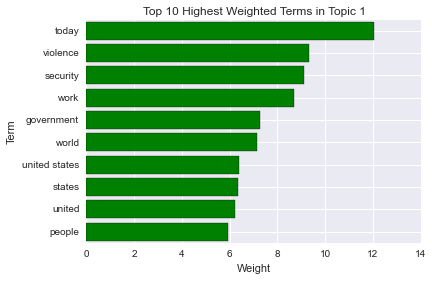


 Topic 2: 

Percentage of Words: 10.19%

strategies performance diplomacy affairs coordination needed begin performance strategies indicators diplomacy pdpa plan expertise resources audiences outreach position officers af pdpa affairs african support officer offices program actions africa office bureau policy needed action pd das media goals posts field begin start pdpa plan lead desk work type paco pao das af pd fy pa ii


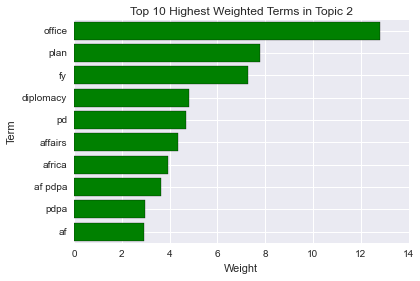


 Topic 3: 

Percentage of Words: 8.82%

question secretary secretary clinton clinton question right question clinton right secretary president everybody question laughter philippe clinton hillary thought country believe working service people monica wanted trying right think going world thing staff phone mean know said want time kind work came make trip went feel did lot don scb say day way try ve


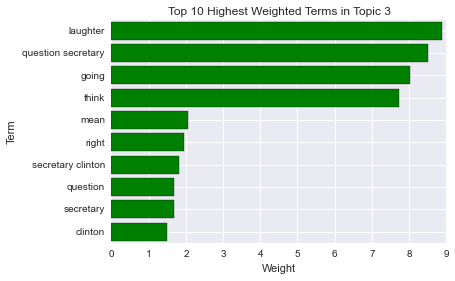


 Topic 4: 

Percentage of Words: 10.74%

republicans health care care reform filibuster amendments washington democrats committee alexander mcconnell amendment senators majority democrat senator members chamber senate reform health corker debate leader baucus people office called house floor rules udall party votes place said vote care dodd time days year reid know rule went want work day tom don


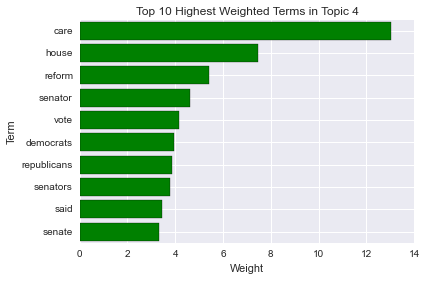


 Topic 5: 

Percentage of Words: 7.71%

ap_popover_sprited background image popover images images amazon lib popover amazon com ecx images com images background image ecx magazines utf node gomorrah popover reading apparel amazon images com gp kindle sports search author books video image games music trial tools node home list baby kids gift wish used com ref utf ecx gif png max lib add gp dp mp


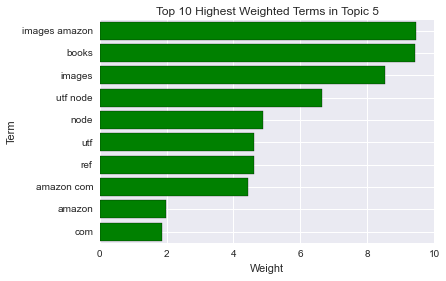


 Topic 6: 

Percentage of Words: 10.42%

patriarch bartholomew constantinople patriarchate archons news nationalists authorities bartholomew government christians minorities patriarch ergenekon christian officials catholics istanbul news asp armenian property reported security churches archons freedom grenade threats members attacks turkey church police asp id people muslim rights greek party court right world turks news said bomb case time asp akp id st


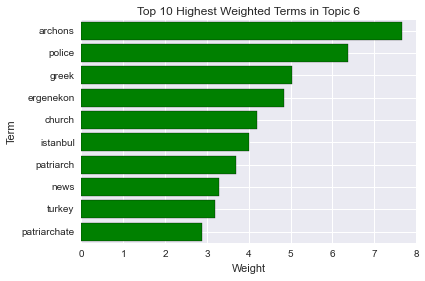


 Topic 7: 

Percentage of Words: 9.68%

assistance programs agency development discussion draft united states administrator states agency development assistance discussion evaluation activities government priorities committees including personnel paragraph resources programs research director analysis congress strategy agencies capacity employee planning expenses program section service states united agency policy report office group draft board usaid funds year term work ment act mdm ii


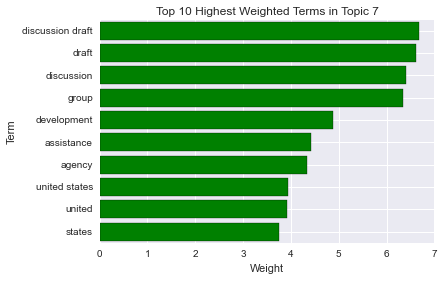


 Topic 8: 

Percentage of Words: 10.09%

administration united states peace process palestinians saudi arabia palestinian government netanyahu jerusalem west bank interests palestine american israelis security minister israeli process leaders america zionism parties support israel states united middle rights called arabia region muslim peace arabs saudi world talks arab jews land west gaza make bank iran time way war end did


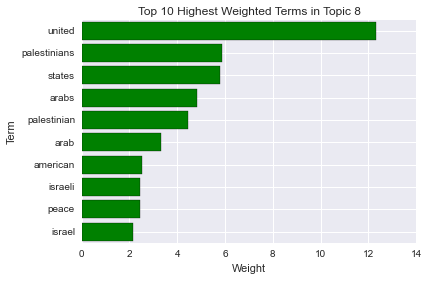


 Topic 9: 

Percentage of Words: 9.22%

michael pelletier concludes depart kitty dimartino american center minutes arrive pelletier cpao judith mchale time minutes depart hotel corley kenna joe mellott drive time ambassador pelletier dimartino concludes consulate american director moriarty michael mellott minutes embassy meeting program pao joe depart arrive mchale judith center mumbai editor wheels corley drive route hotel kitty india staff delhi kenna media time cpao pao joe usg


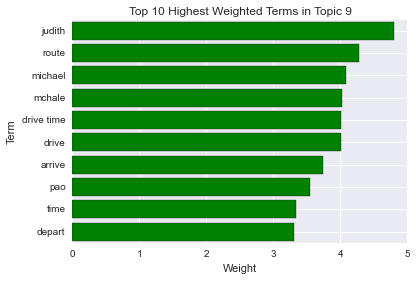


 Topic 10: 

Percentage of Words: 10.38%

president said administration branch writes branch branch relationship branch wjc washington president discussed lewinsky moynihan campaign exchange clinton thought hillary passage mission branch carter writes people called policy needed saying house haiti korea press jesse china gore said book reno life told time trip didn does says wjc hrc did cvc lee run al


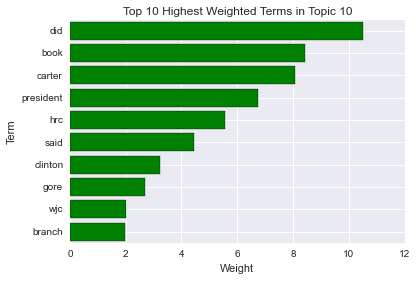


 Topic 11: 

Percentage of Words: 9.21%

qualified hispanics president secretary nhla disappointed positions filled filled positions position filled level positions filled position administration disappointed house house departments commission positions hispanics president appointed secretary qualified remaining personnel executive position hispanic director cabinet appoint affairs filling clinton council filled office course change states health level house urges obama staff labor board known nhla date asst bush vote


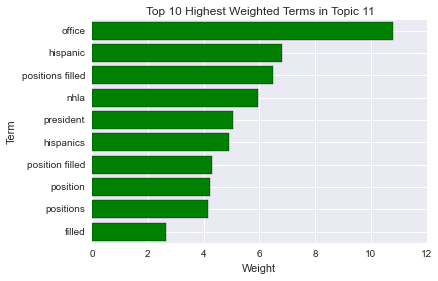


 Topic 12: 

Percentage of Words: 9.50%

americans prosperity koch industries charles david formaldehyde charles koch david koch industries prosperity government foundation americans tea party president institute brothers movement mercatus charles company dollars climate warming center family cancer people called report david kochs party group obama think years money board spent known ideas koch said told time cato york year tea oil tax


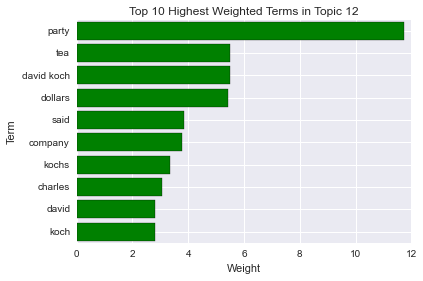


 Topic 13: 

Percentage of Words: 8.28%

according source source comment intelligence governments government according president situation concerned magariaf minister security militias believes benghazi fighting islamist egyptian el keib qaddafi opinion comment leaders sources militia council cabinet islamic source libyan forces belhaj stated regime effort groups libya jalil egypt added keib army time ntc oil scb sid gnc el al


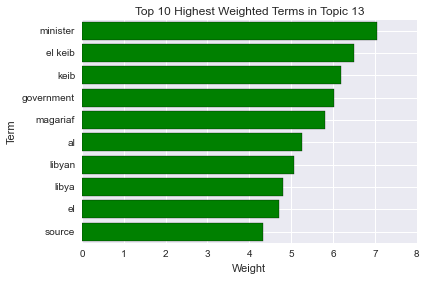


 Topic 14: 

Percentage of Words: 12.76%

administration afghanistan government washington ambassador diplomacy diplomats whitehall pakistan american strategy conflict security invasion taliban support britain chilcot country inquiry afghan troops forces saddam policy effort karzai women blair think meyer asked years iraq need bush time says said week make nato memo come war way did say sir uk


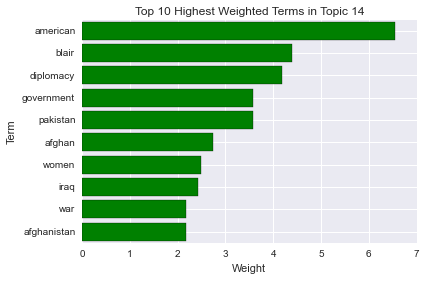


 Topic 15: 

Percentage of Words: 12.41%

mashabane update turkey armenia text davutoglu message abedin armenia text abedin huma huma abedin message sun aug turkey davutoglu brazilian mashabane consulate tomorrow decision attorney let know message armenia sun aug goldman morning michael abedin turkey update family return jacob david today email court press order huma text know time need sean aug sun thu sat let rio ses dec fri


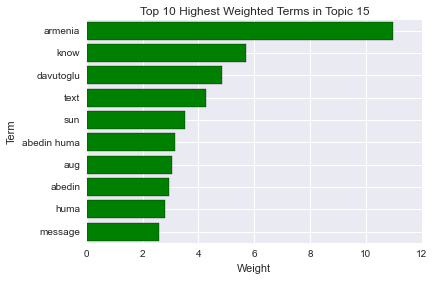


 Topic 16: 

Percentage of Words: 8.40%

developing countries health organization geneva switzerland world health organization development switzerland health care association developing population countries mortality resources diseases research accessed diabetes industry evidence increase capacity disease control tobacco support factors nations address systems poverty health burden policy geneva africa deaths world eases years risks care risk food tion bank jama aids com hiv


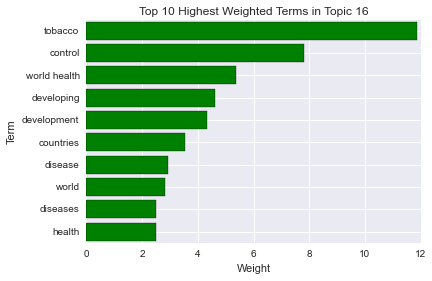


 Topic 17: 

Percentage of Words: 10.17%

security contractors information guard suite washington security embassy contract embassy force contract embassy kabul washington dc guard force supervisors contractors information afghanistan performance downloaded contractor washington armorgroup management oversight situation street nw according wackenhut security contract nw suite services problems embassy mission provide guards afghan combat street senate guard kabul force suite order agna pogo iraq camp zone gov dc nw


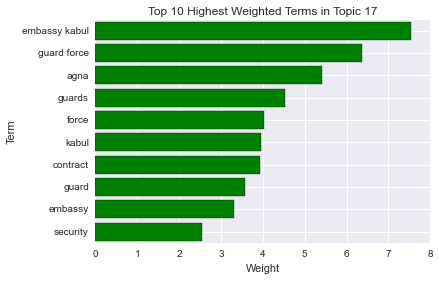


 Topic 18: 

Percentage of Words: 11.30%

reconstruction development port prince trafficking government assistance earthquake conference community education including president children haitians training disaster families recovery haitian support country efforts schools percent message provide people donors relief prince school haiti media needs build money years child work need help said food port term plan team kids aid jan


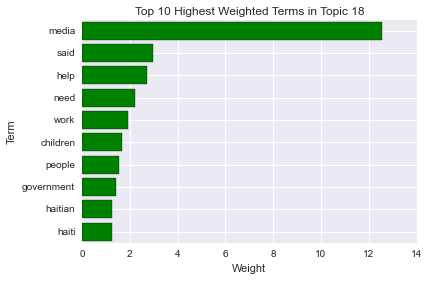


 Topic 19: 

Percentage of Words: 9.90%

secretary conference meeting secretary secretary office arrive residence residence arrive conference room route residence time secretary office meeting staff meeting mini schedule office depart depart route office staff route arrive office time treaty room abedin huma conference room floor washington secretary residence president assistant schedule minister briefing official meeting airport message office arrive depart abedin treaty route staff house floor press photo room time huma mini lona hrc pm


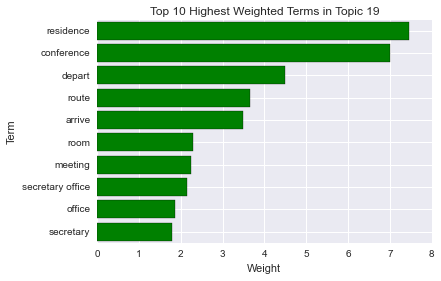


 Topic 20: 

Percentage of Words: 11.60%

climate change united states development cooperation partnership government secretary countries president elections indonesia australia minister malaysia pakistan cambodia security thailand clinton vietnam chinese leaders country climate percent meeting defense nations summit united states region change policy growth issues agreed china asean visit trade japan world korea burma india asia apec year trip


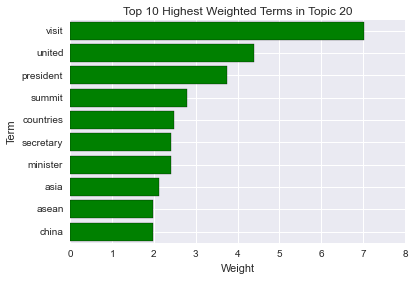


 Topic 21: 

Percentage of Words: 9.30%

pillsbury winthrop quarter report crowell moring winthrop shaw llp pillsbury shaw pittman pittman llp association electronics moring llp university foundation innovation california pillsbury cleveland toiv nora winthrop contacts question students american reported exchange quarter pittman crowell friends message report moring energy rights skill games mount shaw year city term said nora toiv llp end com rep fyi rd nc


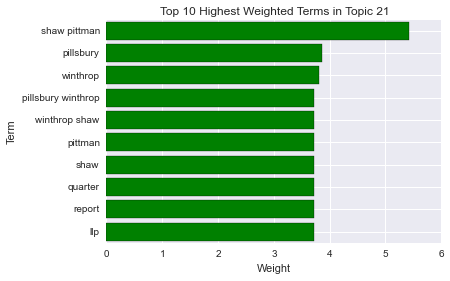


 Topic 22: 

Percentage of Words: 10.38%

issue statement powers devolved power sharing statement sid negotiations guardian uk brava issue bravo brava government agreement sinn fein statement community guardian assembly policing robinson unionist devolved politics sbwhoeop stormont ireland sharing justice parties message belfast cameron gordon powers leader party power peter issue bravo brava peace press said deal sinn fein dup sid feb uup fri uk


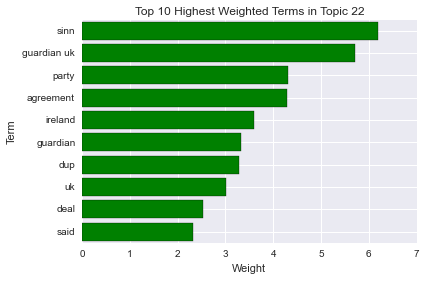


 Topic 23: 

Percentage of Words: 10.08%

republicans health care right wing government healthcare tea party democrats president americans american movement election campaign congress politics skousen boehner percent country society america support history voters reform health called people stupak reagan party obama right house palin group death years power beck wing care john vote poll news time year tea com


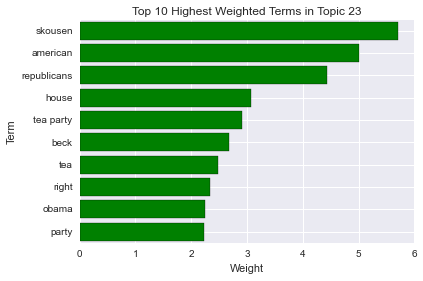


 Topic 24: 

Percentage of Words: 10.46%

obama administration president obama hillary clinton administration barack obama washington president officials mr obama campaign official security election advisers clinton panetta adviser hillary percent emanuel policy people office months barack issues obama house years going aides think staff times gates world said told says bush time iran year role say job don day did mr


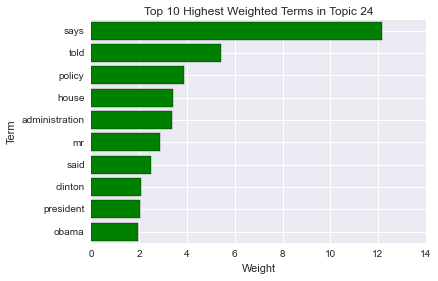

In [615]:
topic_TopWords(nmf2, word_col, 50)


 Topic 1: 

people united states united states world government work security violence today libya benghazi working attack thank indonesia morocco countries american scb minister chris want said pakistan country let help support ambassador continue americans president protect know future colleagues women service peace friends america leaders men believe governments secretary efforts libyan week look personnel year meeting force values lives years ve nations justice embassies life video stevens make sean tunisia steps time protests embassy men women build democracy stand day including events honor understanding places trade tyrone mexico yesterday progress religion way law middle god attacks region remarks nation kind relationship bring glen


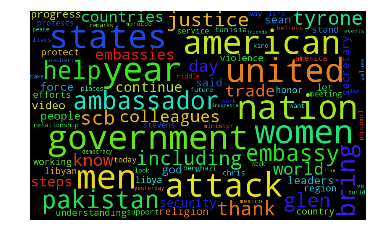


 Topic 2: 

af pdpa af pdpa africa affairs pd diplomacy fy plan office bureau media policy goals strategies african support diplomacy affairs officer outreach pdpa plan position performance pao lead posts coordination field officers pa offices needed expertise desk action resources work das pd das type begin audiences program paco start indicators ii actions needed begin strategies performance performance indicators start timing timing implications engagement paper information paos process staff washington increase deputy diaspora plan action based results africa bureau mission jan development people feb african affairs desks making training american positions goals ii leadership engage activities pd desk understanding priorities communications timing fy pd desks pdod space policy making assistant analysis priority coordinator portfolio bureau african role publics


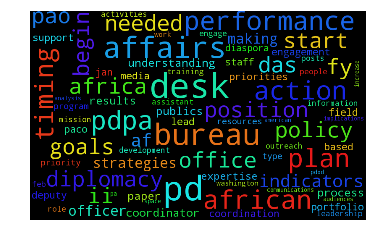


 Topic 3: 

clinton secretary question secretary clinton right mean think going question secretary laughter did people ve clinton question know said lot don want monica president clinton right world right question scb say time hillary thought day wanted kind country work thing everybody came trying way philippe staff make trip went phone believe feel try working service ll told tell didn years right right person got look course let profile job don know security somebody given talk talking saying come office relationship talked transcript house coming respect lot people home hillary clinton dinner unga issues dog york life places ve got responsibility america week moments today gave daughter asked things seen change


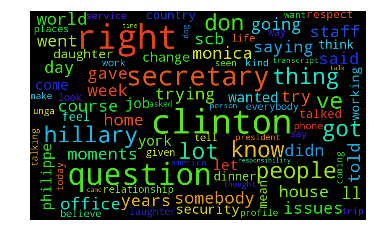


 Topic 4: 

senate said senators republicans democrats vote senator reform house care health care health corker dodd floor time members chamber committee rules majority debate days year alexander udall reid party day filibuster mcconnell know leader baucus rule care reform votes amendment people went office want amendments tom called don place democrat washington work staff legislation way caucus money gregg took say things ve come make let told think did levin minority warner press asked voted president institution mccaskill spent end years room passed com got cloture lobbyists hold colleagues law began thomas afternoon capitol aisle going issue lunch bunning fund dodd said wall times


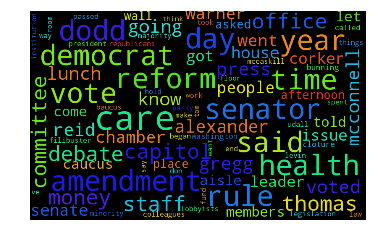


 Topic 5: 

com amazon amazon com ref utf node utf node images books images amazon ecx ecx images com images gp com gp kindle gif png home dp max video image popover popover images lib popover background image background lib image ecx sports ap_popover_sprited list games add baby kids gift wish used search author magazines music reading trial gomorrah mp apparel tools garden product shipping day store supplies newspapers electronics computer blogs book movies software game pc instruments improvement demand reader furniture lawn corner care action light device media office learn shoes car exercise enter idea power food health women york times help message members sign year health care lists start deals tv


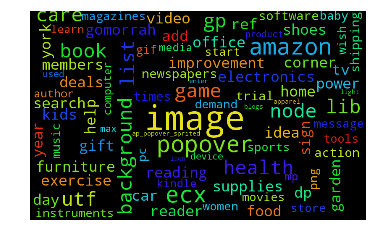


 Topic 6: 

patriarchate turkey news patriarch istanbul church ergenekon greek police archons government id authorities said freedom asp asp id christians bartholomew christian patriarch bartholomew news asp archons news bomb case constantinople party grenade akp officials court right threats minorities nationalists people members armenian property world reported muslim turks attacks time rights st security churches catholics groups article murder ankara religion compound catholic explosion communities mit european used george community alleged reports officers organization freedom religion minority cathedral roof windows called according city life official treaty times murders media office hand belief group harassment circles years army dr day america leaders statement views citizens armed trial demonstrations


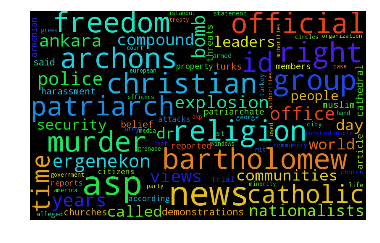


 Topic 7: 

states united united states agency assistance development group discussion draft discussion draft programs policy evaluation program research section report including director administrator analysis office activities government act assistance programs year congress strategy personnel agency development service board states agency usaid term mdm agencies capacity employee planning funds work paragraph ii resources ment priorities committees expenses subsection management support workforce design effectiveness officers following assist training duties coordination title include members policy planning member years submit develop states assistance sec use date appointed states government individuals services purposes implementing operating account objectives force required information secretary recommendations detailed sense employees described pay ensure mission organizations provided resource president opportunities


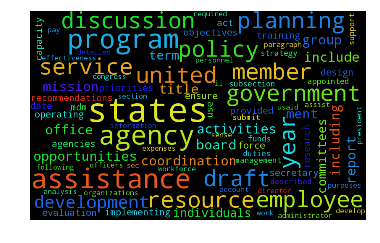


 Topic 8: 

israel peace israeli american arab palestinian arabs states palestinians united united states jews netanyahu process israelis land leaders west middle peace process gaza america saudi make jerusalem administration rights security world zionism way west bank bank interests talks palestine called war arabia saudi arabia end government minister did iran time region parties muslim support diplomacy washington americans does effort settlements european actions com years terrorism settlement community occupation relationship oslo tomorrow groups conflict initiative islamic right muslims people conference self lieberman hamas share peace initiative luntz arab peace council things center partner media reasons students american jews want times begin security council obama administration issue policy accept israeli government speech


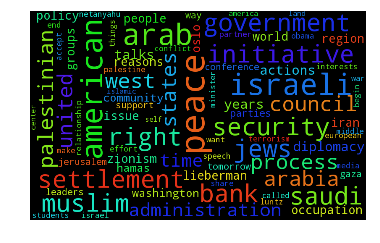


 Topic 9: 

depart time pao arrive drive drive time mchale michael route judith michael pelletier pelletier hotel judith mchale joe mellott minutes joe mellott time minutes kitty dimartino kitty dimartino embassy american center meeting india concludes minutes arrive staff usg cpao ambassador consulate director mumbai pelletier cpao editor concludes depart delhi program wheels kenna corley moriarty american center depart hotel corley kenna pao joe media dhaka lynne travelling party ambassador moriarty travelling bangladesh party lynne gadkowski gadkowski minister participants briefing hotel route lunch staff judith party embassy ron residence location hyatt alumni mchale ambassador participants judith access sheraton airport business dinner executive ministry consul lobby elizabeth time arrive sheraton hotel times mr met tbc fulbright embassy consulate development press remarks meet country managing begins woods room


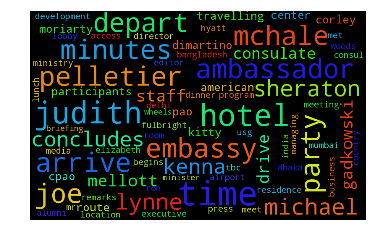


 Topic 10: 

branch wjc gore clinton said hrc president carter book did lewinsky reno thought life hillary moynihan told cvc writes house haiti lee branch writes korea relationship people time trip didn president said press passage called policy campaign needed discussed administration jesse does run branch branch branch wjc china says al washington mission saying exchange having prosecutor chelsea discussing crime janet kissinger rubin portrayed whitewater wanted blame senator message asia speech american note say knew post sense fact light experience vice counsel player silence vernon impeachment said president terror quinn clause vice president tension jackson clinton did example events friends japan lot know think years right asked bhutto


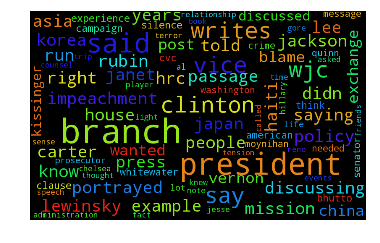


 Topic 11: 

filled positions position position filled hispanics president nhla positions filled hispanic office level house appointed administration secretary qualified level positions qualified hispanics date disappointed nhla disappointed filled positions cabinet filled position urges appoint remaining house house affairs course commission asst president secretary filling obama staff personnel departments bush labor clinton change states vote director health board council executive known services policy agency number community trade obama administration nominated appointments transportation days case security development order defense including office president voted safety population education agencies energy senate service government review assistant commerce deputy confirmation corporation treasury representative george health services veteran represented george bush housing administrator management process united make fact votes united states working


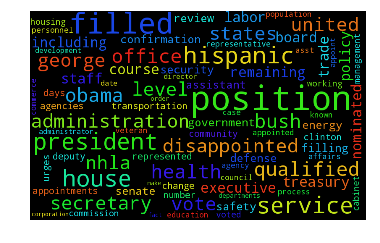


 Topic 12: 

koch david charles kochs company said dollars david koch tea party americans group obama industries prosperity tea party told koch industries americans prosperity brothers center president family government think movement cancer years money institute people oil board called formaldehyde spent tax charles koch time report cato mercatus foundation known climate warming ideas charles david york year companies america site father gave texas citizens fink described control organizations campaign change according committee energy organization went university groups fred web phillips mercatus center members washington web site ve science don school william given bought country paid doherty day foundations economy wing health policy american right politics interests history business funded


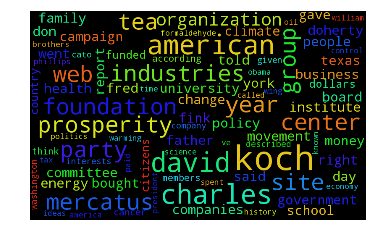


 Topic 13: 

source el libya libyan al magariaf government keib el keib minister qaddafi according jalil forces ntc oil security militias believes president opinion belhaj scb situation comment benghazi source comment fighting army intelligence stated according source islamist governments regime leaders egypt sources militia council time sid cabinet egyptian added effort islamic gnc concerned groups officials country access control services abushagur advisors believe tripoli firms haftar misrata attack troops support juwali lmb el magariaf jcp establish members al juwali supporters libyan council brotherhood efforts european comment opinion intelligence security region nfa mangoush revolution muammar role security services noted abdel source el sources access individuals leader levels ali opinion source group zidan staff attacks hrc


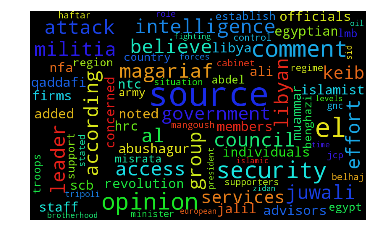


 Topic 14: 

afghanistan war iraq women afghan pakistan government diplomacy blair american need troops forces taliban strategy conflict support bush time britain uk says said week make security chilcot nato country way washington saddam did policy think say diplomats sir ambassador memo effort inquiry invasion meyer asked administration karzai years whitehall come speech world development efforts year weapons force officials want army going al including point don holbrooke number given budget know help sid change allies led right day petraeus soldiers defense power saudi success message work aid europe men president official post london secretary people eu operations america surge times mandelson


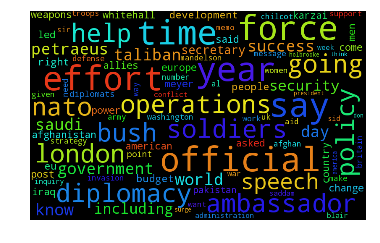


 Topic 15: 

message huma abedin aug abedin huma sun text davutoglu know armenia turkey turkey armenia jacob armenia text text davutoglu tomorrow update message abedin david sun aug goldman time aug turkey thu family morning sat brazilian today let need email decision rio mashabane court sean huma abedin michael ses press attorney return mashabane update let know order dec message sun consulate fri tina amy sep date scanlon scanlon amy kaidanow tina kaidanow tina scanlon pm jacob kaidanow thanks try goldman decision think wed lauren handover james janice jacobs ve oct case lisa thu aug jacobs janice working tue set want aug mashabane bca jiloty managua mary juan wha jiloty lauren hrc huma sun stephen orna gonzalez blum huma jacob craig kubiske agree gonzalez juan


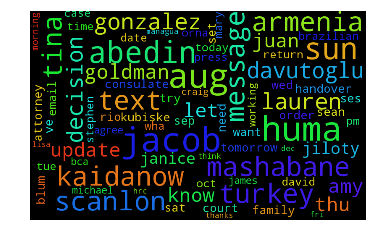


 Topic 16: 

health diseases world disease countries development developing world health control tobacco burden organization health organization developing countries research care risk policy geneva eases com accessed mortality food switzerland geneva switzerland tion support diabetes health care factors africa bank industry nations address evidence deaths years jama aids hiv resources population increase risks systems association poverty capacity need cost action budget sector develop ac leading investment baucus women ing makers mark foundation include governments press house united nations hiv aids developed strategy usaid phrma aid reduce india challenges use policies rates programs united reform prevention web hyman mark hyman government work needs future drug related rights reserved sugar middle rights reserved


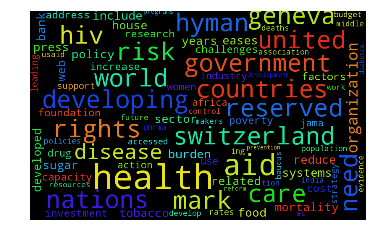


 Topic 17: 

security embassy guard contract kabul force guards agna guard force embassy kabul downloaded pogo contractor supervisors mission afghan combat contractors information oversight washington dc situation afghanistan washington dc nw performance street street nw senate according gov suite wackenhut nw suite suite washington services provide security embassy force contract contract embassy information guard armorgroup security contractors iraq management problems order camp zone officials chain pdf command chain command contracting personnel ng evidence need year environment letter threat case english america reported concerns leadership deficiencies congress language staffing make ability held problem misconduct attachment incorporated government day photographs failure function provided nationals documents complaint functions operations news use consulate forces including incident official facility


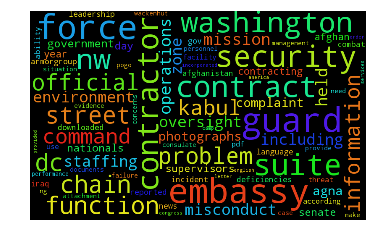


 Topic 18: 

haiti haitian government people children work need help said media donors support assistance aid earthquake country development food efforts relief reconstruction community prince port prince needs port school conference haitians term education build trafficking plan schools team including money years training disaster families president percent recovery jan message child provide kids teachers nations settlements infrastructure haitian government goal working staff crisis emergency donor areas services ground caribbean post fund clinton hope radio response workers coverage corps africa based news report jean mission nation start resources supplies given way set lead agencies usaid funds teacher come program newspaper fyi think haitian people know live


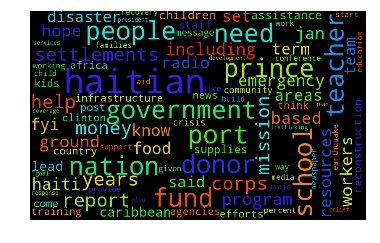


 Topic 19: 

secretary office secretary office meeting room arrive route depart conference residence time conference room staff pm office time secretary conference house time secretary meeting secretary schedule floor depart route huma minister staff meeting mini mini schedule airport office staff office meeting room floor washington abedin treaty treaty room press route residence arrive residence briefing office depart route arrive photo hrc abedin huma president assistant official lona message residence arrive briefing secretary preceding phone spray york deputy office office camera camera spray tbd huma mini residence route fm room meeting depart residence arrive briefing ambassador remarks release abedin franklin franklin room laguardia laguardia airport official photo benjamin dr pre jake hotel deputy secretary contact valmoro assistant secretary washington airport hall secretaries dc building ceremony note house route benjamin franklin room camera arrive house affairs depart hou

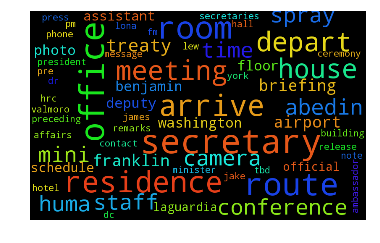


 Topic 20: 

china asean asia minister secretary countries summit president united visit states clinton government vietnam chinese development united states leaders malaysia pakistan trade cambodia region japan country cooperation elections climate percent meeting change policy security world indonesia korea growth burma issues climate change agreed defense india partnership apec thailand year trip australia nations years zealand power efforts sea president obama economy border asian corruption investment singapore relations hanoi ties deal american rights hillary need diplomacy hillary clinton partners agreement members areas ban future budget information held business obama commitment discussed philippines nation infrastructure time republic help secretary clinton environment read islands ministers urged developing way set


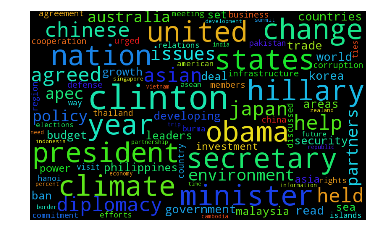


 Topic 21: 

llp report quarter shaw pittman winthrop shaw pillsbury winthrop winthrop pillsbury shaw pittman pittman llp quarter report llp pillsbury moring llp crowell crowell moring moring year skill games association city university foundation friends mount contacts electronics cleveland end innovation energy message question term com said nora toiv nora toiv california students rd nc rep rights american reported exchange fyi thanks reports pa cdm says attachments programs county ig insurance client family fyi message nation llc message toiv samuelson samuelson heather clients question message thanks cdm heather solutions stan filing oversight border lobbying sound amendment hasina ig report press groups id according government rights report exchange programs iranian sbu aspect student youth report haiti embassy taab somalia juarez inspector


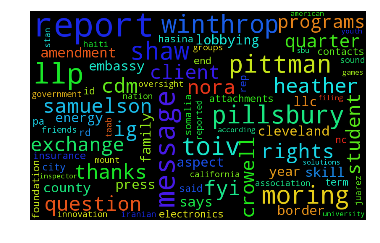


 Topic 22: 

said deal uk dup guardian ireland agreement party guardian uk sinn power fein sinn fein gordon sharing power sharing assembly sid policing powers justice robinson unionist statement peter government parties message devolved issue feb negotiations belfast leader uup issue statement bravo brava brava issue bravo brava statement sid politics community powers devolved peace fri sbwhoeop cameron press stormont weeks unionists uk politics fri feb minister unionist party talks parades peter robinson policing powers sharing government told allister chapter basis said agreement shaun tories election policing justice mcguinness support ulster today justice powers feb bravo vote week way hillsborough martin labour clegg agreed held tory meeting described giving came martin mcguinness set members changed people years confidence sharing deal cowen collapse


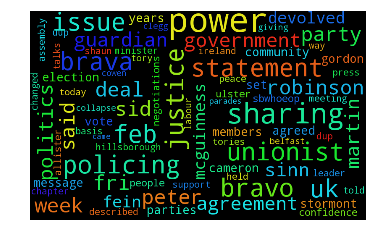


 Topic 23: 

party obama right tea beck tea party house republicans american skousen movement boehner voters democrats wing com right wing care election palin government health care president campaign group reform john percent health vote called poll country news death congress politics time society years america americans year people healthcare support power stupak reagan history gop york activists representative buckley care reform industry nation groups conservatives abortion media book conspiracy fox freedom hitler man leading candidates birch society birch deal university told times welch leader ohio candidate today speaker john boehner opinion economy city wrote era washington life glenn african sbwhoeop agenda sid did mack order party movement claimed


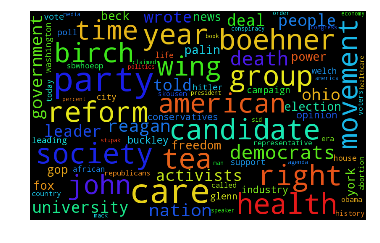


 Topic 24: 

obama president clinton said mr administration house policy told says mr obama people washington bush campaign time iran say years panetta official adviser going security hillary office aides think staff officials percent months president obama year job don day times election did barack hillary clinton barack obama obama administration gates world role emanuel advisers issues romney jones left agency ft got politics week change america netanyahu ve american make presidency strategy program decision things aide lot process meeting didn intelligence rice way team care george rouse circle torture david close took craig congress does mrs clinton case point mrs issue street end security adviser war head fact


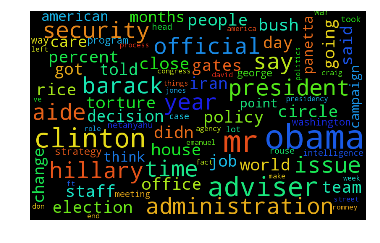

In [616]:
word_clouds(nmf2, word_col, 100)

### Emails by Topic

In [516]:
def emails_topic(X, doc_topics, email_index):
    email_text = X.RawText.ix[email_index]
    email_topics = doc_topics[email_index,:]
    row_sum = np.sum(email_topics, axis=0)
    email_percentages = []
    for topic in email_topics:
        email_percentages.append(topic / float(row_sum))
    plt.bar(range(len(email_percentages)), email_percentages, color='red')
    plt.xlabel('Topic Number')
    plt.xticks(range(0,len(email_percentages)))
    plt.ylabel('Percentage')
    print email_text

**Model 1: 11 Topics**

department state release part sullivan state gov sent subject fw abz hbj libya west bank gaza fyi shapiro daniel ross dennis mcdonough denis burns william sullivan jacob wells alice schrepel dawn schlicher ronald sanderson janet wailes jacob roebuck william bondy steven tsou leslie sutphin paul talwar pune prern rudman mara mitchell george kumar hale david sachar alon nea ipa olson richard lebaron joseph cretz gene polaschlk joan barks ruggles erica stevens john subject abz hb libya west bank gaza sbu had phone calls morning qatari pm fm hamad bin jassim uae minister abdullah bin zayed content was su esting coincidence level uae qatari coordination yesterday arab league meeting points libya related palestinian related are follows sbu fly zone arab league has called nfz unsc needs act syria was hold resolution passed time is wasting hbj abz made right kind noises commitment be kind qatari emirati participation effort chicken egg question was are going support nfz are talk participation 

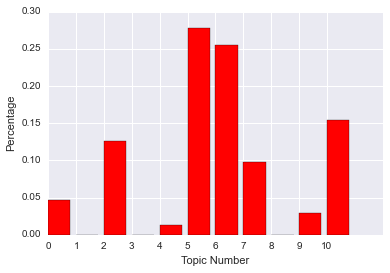

In [600]:
emails_topic(emails_cleaned,W,10)

department state release russorv?state gov sent cc huma abedin abedin huma hanley monica valmoro lona coleman claire subject mini today am depart residence route state department arrive state department am briefing am secretary office staff meeting secretary conference room group photo wffemalle officers africa treaty ksom floor closed press official photographer staff monica ws carson greet escort treaty room approx people attending portuguese interpretation tun meeting ambassador susan rice secretary office am award presentation deputy executive secretary pam quanrud secretary office closed press official photographer staff rob lanta people expected honor award pam meeting assistant secretary mike posner cheryl secretary office pre wfwendy jake wh meeting secretary office depart state department route house am arrive house ii am meeting pm house situation room pm depart house route andrews air force base arrive andrews air force base ceremony return remains department pm colleagues b

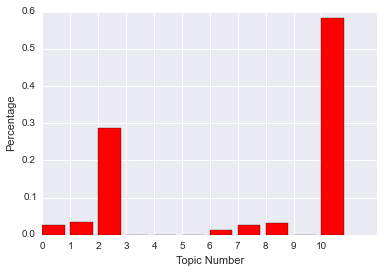

In [606]:
emails_topic(emails_cleaned,W,36)

**Model 2: 24 topics**

department state release part sullivan state gov sent subject fw abz hbj libya west bank gaza fyi shapiro daniel ross dennis mcdonough denis burns william sullivan jacob wells alice schrepel dawn schlicher ronald sanderson janet wailes jacob roebuck william bondy steven tsou leslie sutphin paul talwar pune prern rudman mara mitchell george kumar hale david sachar alon nea ipa olson richard lebaron joseph cretz gene polaschlk joan barks ruggles erica stevens john subject abz hb libya west bank gaza sbu had phone calls morning qatari pm fm hamad bin jassim uae minister abdullah bin zayed content was su esting coincidence level uae qatari coordination yesterday arab league meeting points libya related palestinian related are follows sbu fly zone arab league has called nfz unsc needs act syria was hold resolution passed time is wasting hbj abz made right kind noises commitment be kind qatari emirati participation effort chicken egg question was are going support nfz are talk participation 

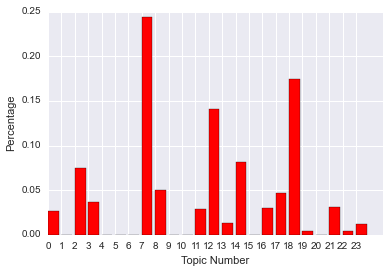

In [617]:
emails_topic(emails_cleaned,W2,10)

department state release russorv?state gov sent cc huma abedin abedin huma hanley monica valmoro lona coleman claire subject mini today am depart residence route state department arrive state department am briefing am secretary office staff meeting secretary conference room group photo wffemalle officers africa treaty ksom floor closed press official photographer staff monica ws carson greet escort treaty room approx people attending portuguese interpretation tun meeting ambassador susan rice secretary office am award presentation deputy executive secretary pam quanrud secretary office closed press official photographer staff rob lanta people expected honor award pam meeting assistant secretary mike posner cheryl secretary office pre wfwendy jake wh meeting secretary office depart state department route house am arrive house ii am meeting pm house situation room pm depart house route andrews air force base arrive andrews air force base ceremony return remains department pm colleagues b

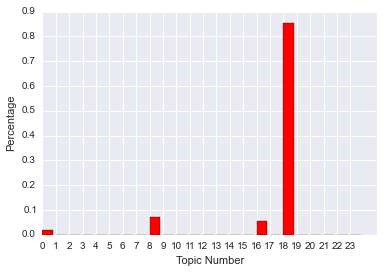

In [618]:
emails_topic(emails_cleaned,W2,36)

## Latent Dirichlet Allocation (LDA)

**Finding Optimal Number of Topics using GridSearch to maximize LDA Maximum Likelihood**

In [27]:
# Source Code: https://github.com/scikit-learn/scikit-learn/tree/master/sklearn/decomposition
# Docs: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
lda_params = {'n_topics':[1,5,10,20,50]}
lda = LatentDirichletAllocation()
lda_grid = GridSearchCV(lda, lda_params)

In [28]:
lda_grid.fit(cv_X)
lda_grid.best_estimator_

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_jobs=1, n_topics=5, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

**After a few runs converged on 5 topics; indicates there is a high degree of uncertainty and dependence between certain topics. LDA does not handle short length of documents well. Area to explore would be seeding with prior distributions of words for topics**

In [543]:
lda_model = LatentDirichletAllocation(n_topics=21, n_jobs=-1).fit(cv_X)

In [544]:
doctopic = lda_model.fit_transform(cv_X)

In [413]:
def topic_EmailsPerYear(topic, doc_topic, X):
    """
    Function to return count of emails with topic per year
    """
    # All emails that contain topic
    emails_with_topic = doc_topic[:,topic].nonzero()
    # 
    emails_with_topic = X[['Year','MetadataSubject']].ix[emails_with_topic]
    emails_year_topic = emails_with_topic.groupby('Year').apply(len)
    print emails_year_topic
    emails_year_topic.plot(kind='barh', color='red', title='Topic {:}: Emails Counts by Year'.format(topic))

In [222]:
# topic_EmailsPerYear(1, doctopic, emails_cleaned)

In [545]:
def topic_TopWords(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print "\n Topic {}: \n".format(topic_idx+1)
        top_words = [feature_names[i] for i in topic.argsort()[::-1][:n_top_words]]
        print ' '.join(sorted(top_words,key=len,reverse=True))

**Topic word weightings for LDA suggest high bias toward names and adjectives**

In [546]:
topic_TopWords(lda_model,word_col,50)


 Topic 1: 

email attachments secretary clinton reflects strength holbrooke asking strength purpose message abedin release cherie abedin shuttle know hillary message sat message tue message sun message thu purpose sis holbrooke secretary aug oprah president rosemarie read week sis love message clinton viruses chinese asking tonite wanted office oprah think obama love said huma gore know time want tue lot thu wed job aug sep sun sat sis dc

 Topic 2: 

release sbwhoeop message sbwhoeop president george israeli minister message jacobi palestinians guardian uk settlements settlement talk today referendum candidates recognized delegation resolution jerusalem jacob sun recommend netanyahu sbwhoeop proposal treasury chinese israeli message thu aug cameron letter freeze return jacobi dollar wishes zelaya peace talks draft likud greek read copy held noon jul aug tom wha tax thu oas

 Topic 3: 

afternoon evening abedin shuttle organizations release huma abedin list ses o_shift huma abedin com

In [547]:
lda_model.score(cv_X)

-23236978.488446325

In [262]:
# topic1_wordslist = [word_col[i] for i in lda_model.components_[0].argsort()[::-1]]
# topic1_words = ' '.join(topic1_wordslist)
# wordcloud = WordCloud(max_font_size=80,relative_scaling=.5,width=800,height=500).generate(topic1_words)


 Topic 1: 

immediate assistance earlier year preventing stan contractors attract harry reid reynoso julissa brother scenario pirro does provide impressive minister said narrow promoting size forthcoming relies economic development international community cost belfast phones sinn effect lindwall james lew hiding mainly properly critical function attempts focuses posture uniform release slaughter sought killing retain sent office bills abuse wi editor offensive promote outcome outreach


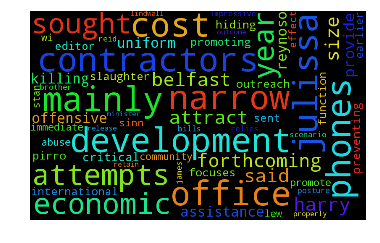


 Topic 2: 

chiefs staff lengthy joint chiefs officials said takeover uup familiar weren greeted general petraeus denial wished extension bloomberg earned ulster democrat beat presidential candidate inauguration signals lawmakers quake anonymity broke shut haiti earthquake adults concessions anger news nea hired news mahogany married acknowledge envoys characterized mahogany forge massive mentioning abide fred falling chiefs polls historically federal reserve hillsborough aide


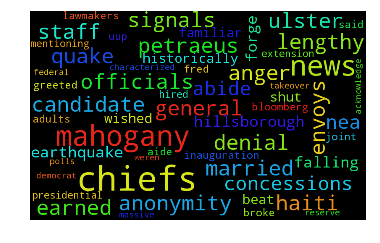


 Topic 3: 

funds outstanding quake food aid zones stages riots fuel medicine gdp multilateral impunity models fy increases conceived capabilities darfur incentives accounts advancing insecurity coming weeks alternative developing countries haiti earthquake occurs global economic patients contractors strengthening floods signal mechanisms employment facilitate family planning undertake contribution global health indicators diseases trends tracks electricity trillion economic social confused academics farmers


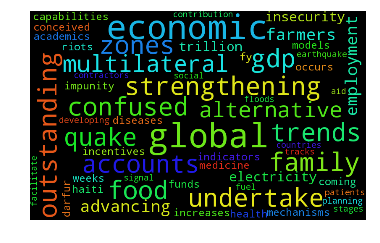


 Topic 4: 

overcome north south uup ad general petraeus ulster jacobson roberta subsequent release slaughter blast reynoso julissa sent hrc hillsborough member states trying make revised draft reflected merten lib dems roberta mail blackberry ulster unionist sent cingular xpress mail ahmed adults cingular xpress xpress cingular message feltman lady ashton dup gun merten kenneth reg dimartino kitty eastern europe empey concessions tue mar favour ibrahim main parties leader peter robinson said ashton qureshi christmas power sharing sinn


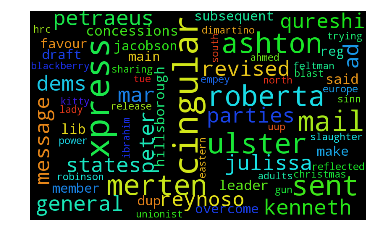


 Topic 5: 

resigned ad news mahogany sent update singh mahogany reuters alternative mountain consular ap reynoso julissa procedures stations investigating struggling attempted president hamid courts entry acknowledging prosecutors undemocratic official said pressured paying avoided apparently damaged million people custody accountable observation resulted mahogany ses damaging arrested monetary acknowledged ca accounts false papers somalia rso blocks attempts declared dozen bomb


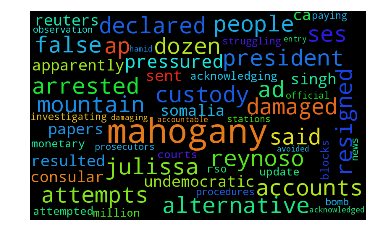


 Topic 6: 

ad merten kenneth release slaughter preventing currency vast merten accompanied hired sovereignty reynoso julissa merely lindwall designated acted acknowledging md laying american jewish chronic quake clarification alliances newsweek remembered relative conveyed vilsack theories regret haiti earthquake observed substantial pursuit temporarily locally lindwall david justin settlement freeze government people cap reflect objection contractors fred pirro nutrition earlier year consequences methods


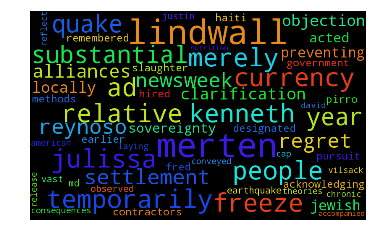


 Topic 7: 

donald fail require carter marie used supporting bolivia ian presidency stewart york times apparently tennessee native standards despite aggressively largest negotiated huma mini reforms food blumenthal operate months bankers moves effective hiring train trade leaves melanne sent portfolio board votes global pentagon updates hemisphere quickly activity washington national million improve undermined contract president obama chiefs staff


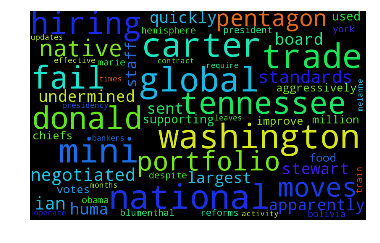


 Topic 8: 

st nw nato allies crusade discrimination czech republic sexual violence cingular xpress cindy sent adviser neill ally thessin favorable thessin james nuclear impunity rape cingular mail blackberry protecting worst conservatives sbwhoeop directed rose food ed used kinshasa property sbwhoeop sent policies op ed congo subsequent goma hongju koh editor st century congolese cindy koh legal sooner message sbwhoeop causing koh harold tories arms control threat security long range


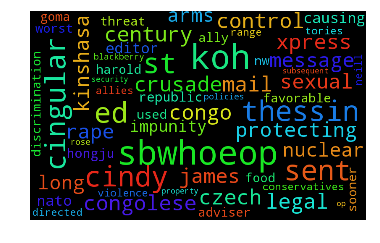


 Topic 9: 

intimidation burning stages funds sufficient defense minister execute undertake economic development nc cost ranks lengthy apparently association menendez decade douglas attempted beat divorce defeat reforms require reliable involves counting responsibilities carter referred york times arena born avoided professor projects costs long time drugs tracks strengthen nation means responsible gap stan native extend months criminal


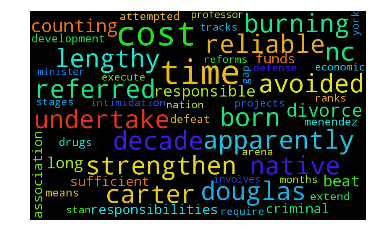


 Topic 10: 

lew jacob release slaughter reynoso julissa blair message direct original sheikha fri jan ams campbell piper mcgovern mosa merten kenneth message cherie sheikha mosa mosa qatar ashton cherie blair merten teleconference dinner original lady ashton message scanned scanned mailcontroller lissa sent fuchs mailcontroller cherie slaughter anne wed feb blair sent deputies meetings lindwall scanned pirro lindwall david altohiway mailcontroller altohiway altohiway com marie abedin www mailcontroller want let sullivan huma quake latest draft counting ian pace sat feb lissa muscatine xpress mail early week


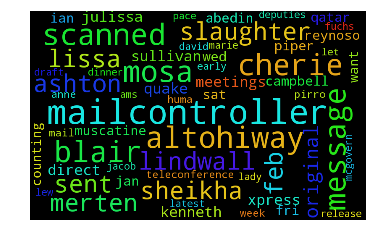


 Topic 11: 

merten kenneth rajiv merten uup lindwall reynoso julissa outright borders release slaughter general petraeus pirro arabia lindwall david hillsborough quake kandahar wing ulster saudi arabia impasse velia sinn welfare dimartino kitty adults reg haiti earthquake harry pirro velia washington national dup suffer fuchs dimartino greeted lib dems unionist sinn fein empey kitty concessions ulster unionist peter robinson happy new leader peter persuade qureshi authoritarian fuchs michael sent mchale


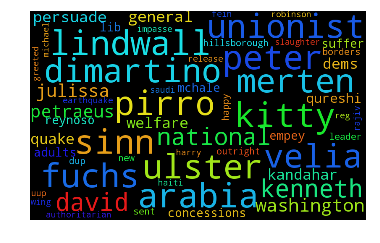


 Topic 12: 

reynoso julissa merten kenneth sent lew merten lindwall pirro lindwall david direct original sarah velia dimartino kitty smith daniel pirro velia reynolds dimartino luzzatto kitty general petraeus fuchs uup roberta reynoso janice los donald fuchs michael message valenzuela samuelson consular james lew sent mchale consular affairs haiti earthquake st nw jilotylcstate gov sent update ulster ocs release huma lady ashton sun dec jacobs janice hi huma cooper hillsborough jilotylcstate samuelson heather mcguinness tue mar sent followup


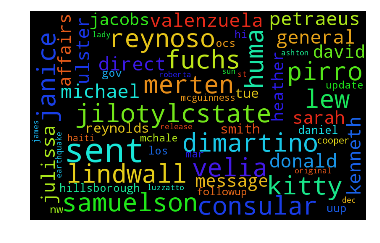


 Topic 13: 

donald excited jacob macmanus sa ship smith daniel secretary original menendez intervention understood updates sent update stan justin patrick sitting exclusive ad maria otero appearance kennedy patrick encourage veteran funds food letters apparently option kelly ian boys update original praising father macmanus joseph complete used authorized ian pace refugee gap govt shannon wall dying scale born crowley philip macmanus basic contract


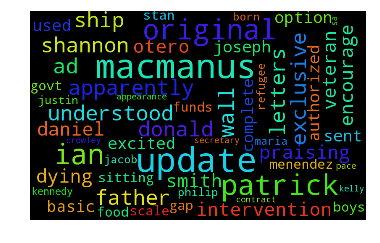


 Topic 14: 

ad uup jews ulster ups quake ulster unionist greeted dimartino kitty hillsborough adults haiti earthquake dimartino kitty ref wikipedia ajc lobbyist merten click toll xpress consul release slaughter cingular xpress html xpress mail brother mail blackberry king abdullah main parties favour robinson said leader peter search sir pipeline sent cingular src max blumenthal appalling website sbwhoeop cingular http www privacy policy reveals newspapers http blog interfere


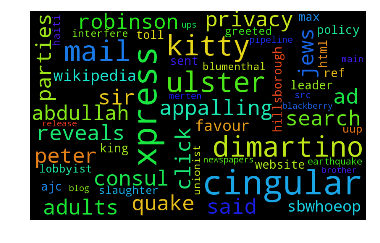


 Topic 15: 

release slaughter sbwhoeop taliban cold sbwhoeop sent missile rates departments tories slaughter anne american foreign predecessor emissions peoples brown cold war sent slaughter message sbwhoeop marie anne marie sent sbwhoeop anne western alliance mr obama slaughter merkel unlike presidency carbon nsc filled dispute chinese government nov president picks generals marie sent alliance accord new government environmental offers marie slaughter policy brandenburg gate roads predecessors wing


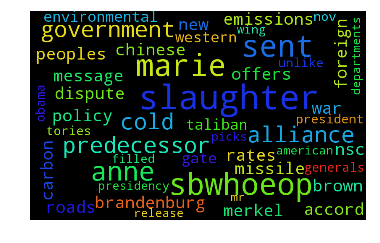


 Topic 16: 

menendez praising kelly ian smith daniel excited lew jacob ad sent lew sa ian pace maria otero imperative updates racism homeland security presumably residents cut intervention funds af supply african american bills sent update update original isaf publication tracks democrat otero middle class accounts boys carter limited millennium challenge public service apparently disclose contract millennium jacobs income city undertake alice barack waste adviser


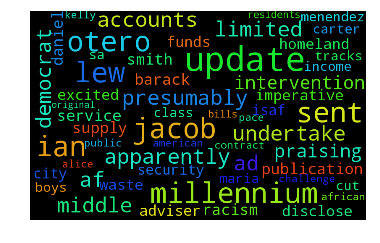


 Topic 17: 

va melanne sent scale refugee surely regret portfolio embassy london suggesting alleging incumbent divorce income match stages allowed recalled arrangement handful function african american journal lay execute maker newsweek accounts contract proud billy feelings inherent organisations directed cingular xpress hand sold authorized remained deep win conduct vision long time repeatedly sung effect responsibilities repair ultimately


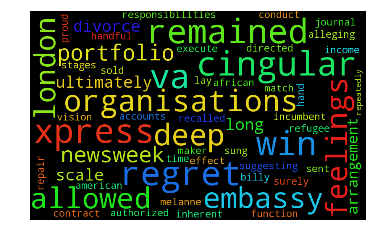


 Topic 18: 

vast shifts bosnia employed conveyed strengthening uup merely significantly unfair contractors international community law enforcement scale bipartisan support advancing realized public opinion taxpayer hired beat wing covers ar sarah investigations cut funds increases governance ulster bonds earlier year alternative surely hamid karzai destruction zones refugee income consequences attract accountable merits los minority size abuse limits massachusetts avenue


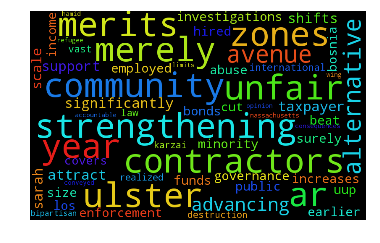

In [97]:
word_clouds(lda_model, word_col, 50)

In [96]:
def word_clouds(model, word_list, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print "\n Topic {}: \n".format(topic_idx+1)
        topic_wordlist = [word_list[i] for i in model.components_[topic_idx].argsort()[::-1][:n_top_words]]
        topic_words = ' '.join(topic_wordlist)
        print topic_words
        wordcloud = WordCloud(max_font_size=80,relative_scaling=.5,width=800,height=500).generate(topic_words)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

## Challenges

Dataset was a carefully selected subset of emails with a heavy emphasis towards Libya  
Highly unbalanced classes with strong bias toward short emails that hurt topic modeling  
Extremely messy data with PDF conversion errors, encoding issues, abbreviations, etc.  
Relationships in data highly complex and not independent  
Visualization Lesson: stacked bar charts work with limited items

## Potential Future Directions

Try LDA implementation in Gensim for improved performance  
Try Noun Phrases in POS filtering  
Run text through a spell checker  

## Extra Credit: How would you turn your project in a data product?

Generalized topic model analyzer for improved search through emails

In [ ]:
class TopicModeler(object):
    def __init__()
    self.model
    self.doc_topic
    self.topic_words
    
    def fit()
    def topic_by_year()
    def emails_by_topic()
    def wordcloud()

**Research**

http://blog.dominodatalab.com/topic-modeling-in-sept-11-news-articles/
https://de.dariah.eu/tatom/topic_model_python.html
https://github.com/sandinmyjoints/gensimtalk/blob/master/gensim_example.py
https://de.dariah.eu/tatom/topic_model_visualization.html
http://radimrehurek.com/topic_modeling_tutorial/2%20-%20Topic%20Modeling.html
http://derekgreene.com/nmf-topic/

http://sujitpal.blogspot.com/2014/08/topic-modeling-with-gensim-over-past.html
http://derekgreene.com/howmanytopics/